<a href="https://colab.research.google.com/github/mjkleiman/streamlineAD/blob/master/KleimanPhD_Chp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

!pip install eli5
!pip install rfpimp
!pip install scikit-plot
import scikitplot as skplt

from google.colab import drive
drive.mount('/content/gdrive')
dir='/content/gdrive/My Drive/Dissertation/'

device_name = tf.test.gpu_device_name() # Make sure the GPU is running on Colab
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


# Prelims

In [0]:
adni_X = pd.read_csv(f'{dir}/Data/adni_X_scale.csv')
adni_y2 = pd.read_csv(f'{dir}/Data/adni_y2.csv')
adni_y3 = pd.read_csv(f'{dir}/Data/adni_y3.csv')

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split as split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import xgboost
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

%matplotlib inline
sns.set_style("whitegrid", rc = {'figure.figsize':(15, 10)})


def ehr_analyses(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy','AUC'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)

  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('\n')
  print(classification_report(y, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('\n')
  print(classification_report(y, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('\n')
  print(classification_report(y, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'LogRegression','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('\n')
  print(classification_report(y, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'SVM','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
 
  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('\n')
  print(classification_report(y, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  return df

def ehr_analyses3(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)

  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
  scores_mlp = cross_val_score(mlp, X, y.values.ravel(), cv=cv, n_jobs=1)
    
  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  return df



def ehr_feature(X, y, clf='rf', random_state=0, test_size=0.2):
  '''
  Plots and notes the feature importances using two consecutive methods:
    Permutation importance (in which a variable is replaced with noise) and
    Drop-column importance (in which a variable is dropped completely from the
    model)
    
  Classifier can be either random forest ('rf') or xgboost ('xgb')
  
  '''
  X_train, X_test, y_train, y_test = split(X, y.values.ravel(), test_size=test_size, random_state=random_state)
  
  # Select classifier ('rf' or 'xgb')
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show();plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train, X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  plt.show();plt.clf()
  
  df = df.merge(drop, on='Feature', how='left')
  return df

In [0]:
def paired_analyses(X_train, y_train, X_test, y_test, random_state=0):
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  rf.fit(X_train, y_train.values.ravel())
  
  y_pred = rf.predict(X_test)
  print('~~Random Forest~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('\n')
  print(classification_report(y_test, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y_test, y_pred), 'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  xgb.fit(X_train, y_train.values.ravel())
  
  y_pred = xgb.predict(X_test)
  print('~~XGBoost~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('\n')
  print(classification_report(y_test, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
  mlp.fit(X_train, y_train.values.ravel())

  y_pred = mlp.predict(X_test)
  print('~~MLP~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('\n')
  print(classification_report(y_test, np.rint(y_pred)))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  return df

def paired_feature(X_train, y_train, X_test, y_test, clf='rf', random_state=0):
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train.values.ravel()) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train.values.ravel(), X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  df = df.merge(drop, on='Feature', how='left')
  return df


# Domains - ADNI

### Short Term Memory

In [0]:
stm = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg']

adni_stm = adni_X.loc[:,stm]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[269 115]
 [ 85 623]]
Accuracy: 	 0.8168498168498168
AUC: 		 0.790232168079096


              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73       384
         1.0       0.84      0.88      0.86       708

    accuracy                           0.82      1092
   macro avg       0.80      0.79      0.80      1092
weighted avg       0.81      0.82      0.82      1092



~~XGBoost~~
[[294  90]
 [100 608]]
Accuracy: 	 0.826007326007326
AUC: 		 0.8121910310734464


              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       384
         1.0       0.87      0.86      0.86       708

    accuracy                           0.83      1092
   macro avg       0.81      0.81      0.81      1092
weighted avg       0.83      0.83      0.83      1092



~~Logistic Regression~~
[[283 101]
 [ 93 615]]
Accuracy: 	 0.8223443223443223
AUC: 		 0.802811617231

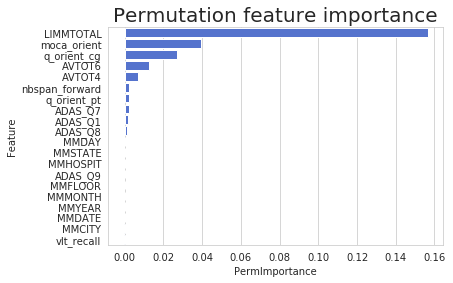

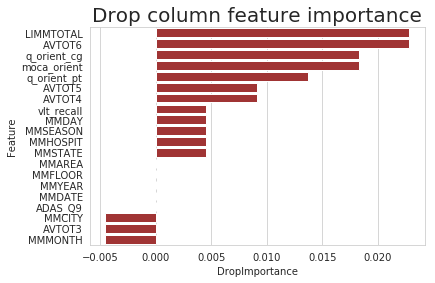

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_stm_2 = ehr_analyses(adni_stm, adni_y2)
ehr_stm_2.to_csv(f'{dir}/Output/ehr_stm_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_stm_2 = ehr_feature(adni_stm, adni_y2)
features_stm_2.to_csv(f'{dir}/Output/features_stm_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_stm_3 = ehr_analyses3(adni_stm, adni_y3)
# ehr_stm_3.to_csv(f'{dir}/Output/ehr_stm_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_stm_3 = ehr_feature(adni_stm, adni_y3)
# features_stm_3.to_csv(f'{dir}/Output/features_stm_3.csv', index=False)


### Long Term (delay) Memory

In [0]:

ltm = ['moca_recall','ADAS_Q4','MMBALLDL', 'MMFLAGDL', 'MMTREEDL', 'LDELTOTAL', 'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2',
      'q_memory_pt','q_memory_cg']
adni_ltm = adni_X.loc[:,ltm]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[297  87]
 [ 58 650]]
Accuracy: 	 0.8672161172161172
AUC: 		 0.8457582980225988


              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       384
         1.0       0.88      0.92      0.90       708

    accuracy                           0.87      1092
   macro avg       0.86      0.85      0.85      1092
weighted avg       0.87      0.87      0.87      1092



~~XGBoost~~
[[305  79]
 [ 55 653]]
Accuracy: 	 0.8772893772893773
AUC: 		 0.8582936087570622


              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       384
         1.0       0.89      0.92      0.91       708

    accuracy                           0.88      1092
   macro avg       0.87      0.86      0.86      1092
weighted avg       0.88      0.88      0.88      1092



~~Logistic Regression~~
[[307  77]
 [ 64 644]]
Accuracy: 	 0.8708791208791209
AUC: 		 0.8545418432

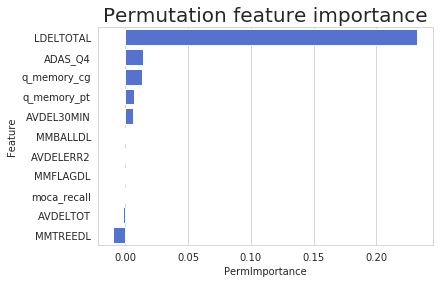

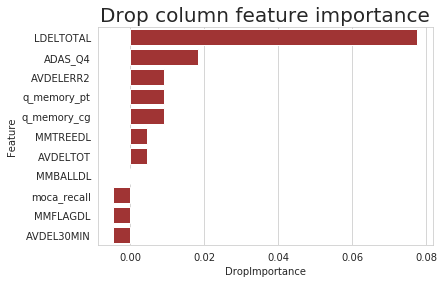

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_ltm_2 = ehr_analyses(adni_ltm, adni_y2)
ehr_ltm_2.to_csv(f'{dir}/Output/ehr_ltm_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_ltm_2 = ehr_feature(adni_ltm, adni_y2)
features_ltm_2.to_csv(f'{dir}/Output/features_ltm_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_ltm_3 = ehr_analyses3(adni_ltm, adni_y3)
# ehr_ltm_3.to_csv(f'{dir}/Output/ehr_ltm_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_ltm_3 = ehr_feature(adni_ltm, adni_y3)
# features_ltm_3.to_csv(f'{dir}/Output/features_ltm_3.csv', index=False)


### Attention

In [0]:

att = ['moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg']
adni_att = adni_X.loc[:,att]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[265 119]
 [168 540]]
Accuracy: 	 0.7371794871794872
AUC: 		 0.7264080155367232


              precision    recall  f1-score   support

         0.0       0.61      0.69      0.65       384
         1.0       0.82      0.76      0.79       708

    accuracy                           0.74      1092
   macro avg       0.72      0.73      0.72      1092
weighted avg       0.75      0.74      0.74      1092



~~XGBoost~~
[[272 112]
 [163 545]]
Accuracy: 	 0.7481684981684982
AUC: 		 0.7390536723163842


              precision    recall  f1-score   support

         0.0       0.63      0.71      0.66       384
         1.0       0.83      0.77      0.80       708

    accuracy                           0.75      1092
   macro avg       0.73      0.74      0.73      1092
weighted avg       0.76      0.75      0.75      1092



~~Logistic Regression~~
[[265 119]
 [161 547]]
Accuracy: 	 0.7435897435897436
AUC: 		 0.7313515183

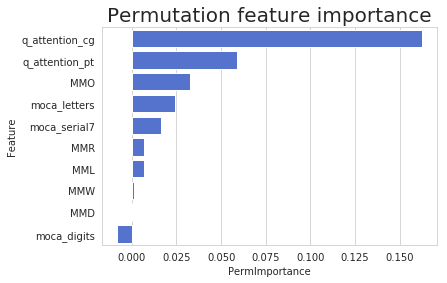

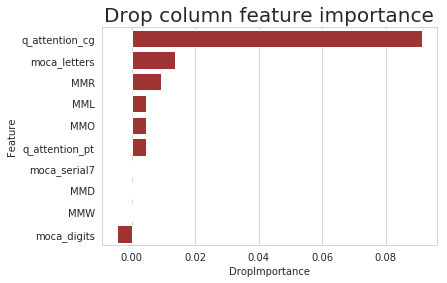

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_att_2 = ehr_analyses(adni_att, adni_y2)
ehr_att_2.to_csv(f'{dir}/Output/ehr_att_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_att_2 = ehr_feature(adni_att, adni_y2)
features_att_2.to_csv(f'{dir}/Output/features_att_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_att_3 = ehr_analyses3(adni_att, adni_y3)
# ehr_att_3.to_csv(f'{dir}/Output/ehr_att_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_att_3 = ehr_feature(adni_att, adni_y3)
# features_att_3.to_csv(f'{dir}/Output/features_att_3.csv', index=False)


### Executive Functioning

In [0]:

exf = ['moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_X.loc[:,exf]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[236 148]
 [213 495]]
Accuracy: 	 0.6694139194139194
AUC: 		 0.6568679378531073


              precision    recall  f1-score   support

         0.0       0.53      0.61      0.57       384
         1.0       0.77      0.70      0.73       708

    accuracy                           0.67      1092
   macro avg       0.65      0.66      0.65      1092
weighted avg       0.68      0.67      0.67      1092



~~XGBoost~~
[[270 114]
 [239 469]]
Accuracy: 	 0.6767399267399268
AUC: 		 0.6827771892655368


              precision    recall  f1-score   support

         0.0       0.53      0.70      0.60       384
         1.0       0.80      0.66      0.73       708

    accuracy                           0.68      1092
   macro avg       0.67      0.68      0.67      1092
weighted avg       0.71      0.68      0.68      1092



~~Logistic Regression~~
[[244 140]
 [177 531]]
Accuracy: 	 0.7097069597069597
AUC: 		 0.6927083333

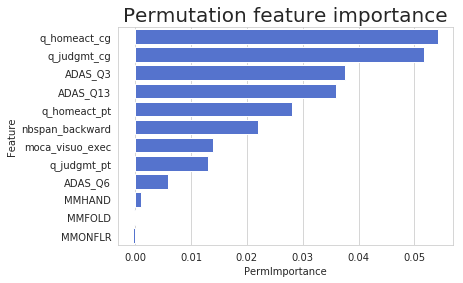

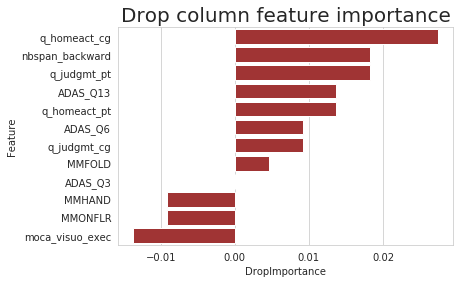

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_exf_2 = ehr_analyses(adni_exf, adni_y2)
ehr_exf_2.to_csv(f'{dir}/Output/ehr_exf_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_exf_2 = ehr_feature(adni_exf, adni_y2)
features_exf_2.to_csv(f'{dir}/Output/features_exf_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_exf_3 = ehr_analyses3(adni_exf, adni_y3)
# ehr_exf_3.to_csv(f'{dir}/Output/ehr_exf_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_exf_3 = ehr_feature(adni_exf, adni_y3)
# features_exf_3.to_csv(f'{dir}/Output/features_exf_3.csv', index=False)


### Visuospatial

In [0]:

vis = ['moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM']
adni_vis = adni_X.loc[:,vis]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[161 223]
 [160 548]]
Accuracy: 	 0.6492673992673993
AUC: 		 0.5966410663841808


              precision    recall  f1-score   support

         0.0       0.50      0.42      0.46       384
         1.0       0.71      0.77      0.74       708

    accuracy                           0.65      1092
   macro avg       0.61      0.60      0.60      1092
weighted avg       0.64      0.65      0.64      1092



~~XGBoost~~
[[140 244]
 [143 565]]
Accuracy: 	 0.6456043956043956
AUC: 		 0.5813029661016949


              precision    recall  f1-score   support

         0.0       0.49      0.36      0.42       384
         1.0       0.70      0.80      0.74       708

    accuracy                           0.65      1092
   macro avg       0.60      0.58      0.58      1092
weighted avg       0.63      0.65      0.63      1092



~~Logistic Regression~~
[[100 284]
 [ 97 611]]
Accuracy: 	 0.6510989010989011
AUC: 		 0.5617055084

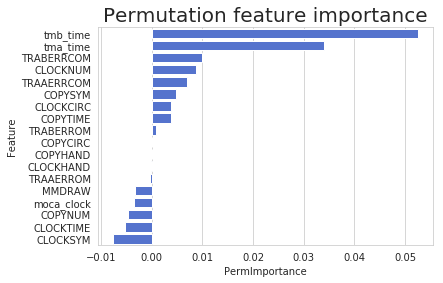

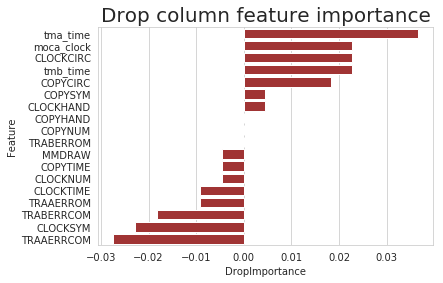

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_vis_2 = ehr_analyses(adni_vis, adni_y2)
ehr_vis_2.to_csv(f'{dir}/Output/ehr_vis_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_vis_2 = ehr_feature(adni_vis, adni_y2)
features_vis_2.to_csv(f'{dir}/Output/features_vis_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_vis_3 = ehr_analyses3(adni_vis, adni_y3)
# ehr_vis_3.to_csv(f'{dir}/Output/ehr_vis_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_vis_3 = ehr_feature(adni_vis, adni_y3)
# features_vis_3.to_csv(f'{dir}/Output/features_vis_3.csv', index=False)


### Language

In [0]:

lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','ADAS_Q2',
       'ADAS_Q5','ADAS_Q10','ADAS_Q11','ADAS_Q12','MMBALL', 'MMFLAG', 'MMTREE',
       'MMWATCH', 'MMPENCIL','MMREPEAT','MMREAD', 'MMWRITE',
       'CATANIMSC', 'CATVEGESC', 'q_language_pt','q_language_cg']
adni_lng = adni_X.loc[:,lng]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[239 145]
 [165 543]]
Accuracy: 	 0.7161172161172161
AUC: 		 0.694672492937853


              precision    recall  f1-score   support

         0.0       0.59      0.62      0.61       384
         1.0       0.79      0.77      0.78       708

    accuracy                           0.72      1092
   macro avg       0.69      0.69      0.69      1092
weighted avg       0.72      0.72      0.72      1092



~~XGBoost~~
[[268 116]
 [181 527]]
Accuracy: 	 0.728021978021978
AUC: 		 0.7211334745762713


              precision    recall  f1-score   support

         0.0       0.60      0.70      0.64       384
         1.0       0.82      0.74      0.78       708

    accuracy                           0.73      1092
   macro avg       0.71      0.72      0.71      1092
weighted avg       0.74      0.73      0.73      1092



~~Logistic Regression~~
[[244 140]
 [131 577]]
Accuracy: 	 0.7518315018315018
AUC: 		 0.725194209039

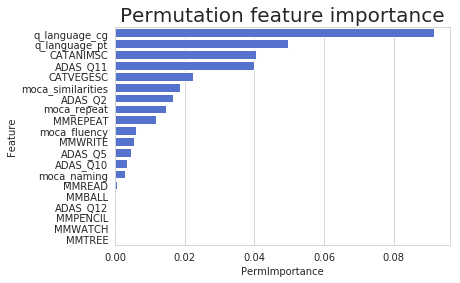

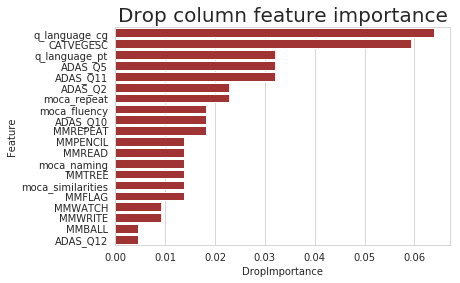

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_lng_2 = ehr_analyses(adni_lng, adni_y2)
ehr_lng_2.to_csv(f'{dir}/Output/ehr_lng_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_lng_2 = ehr_feature(adni_lng, adni_y2)
features_lng_2.to_csv(f'{dir}/Output/features_lng_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_lng_3 = ehr_analyses3(adni_lng, adni_y3)
# ehr_lng_3.to_csv(f'{dir}/Output/ehr_lng_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_lng_3 = ehr_feature(adni_lng, adni_y3)
# features_lng_3.to_csv(f'{dir}/Output/features_lng_3.csv', index=False)

### All memory


In [0]:

mem = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall','ADAS_Q4','MMBALLDL', 
       'MMFLAGDL', 'MMTREEDL', 'LDELTOTAL', 'AVDEL30MIN', 
       'AVDELTOT', 'AVDELERR2','q_memory_pt','q_memory_cg']
adni_mem = adni_X.loc[:,mem]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[300  84]
 [ 49 659]]
Accuracy: 	 0.8782051282051282
AUC: 		 0.8560204802259888


              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       384
         1.0       0.89      0.93      0.91       708

    accuracy                           0.88      1092
   macro avg       0.87      0.86      0.86      1092
weighted avg       0.88      0.88      0.88      1092



~~XGBoost~~
[[306  78]
 [ 54 654]]
Accuracy: 	 0.8791208791208791
AUC: 		 0.860301906779661


              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82       384
         1.0       0.89      0.92      0.91       708

    accuracy                           0.88      1092
   macro avg       0.87      0.86      0.87      1092
weighted avg       0.88      0.88      0.88      1092



~~Logistic Regression~~
[[321  63]
 [ 71 637]]
Accuracy: 	 0.8772893772893773
AUC: 		 0.86782750706

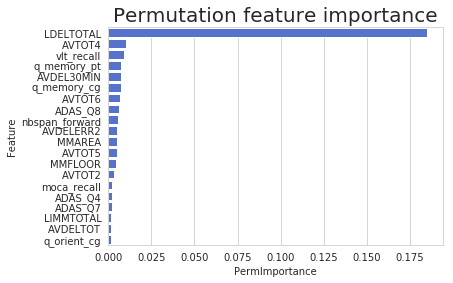

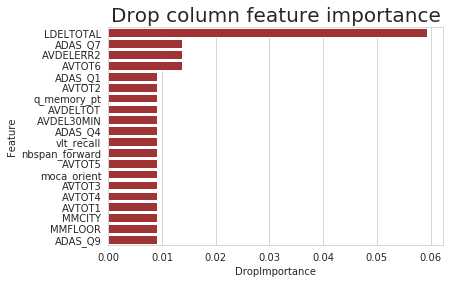

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_mem_2 = ehr_analyses(adni_mem, adni_y2)
ehr_mem_2.to_csv(f'{dir}/Output/ehr_mem_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_mem_2 = ehr_feature(adni_mem, adni_y2)
features_mem_2.to_csv(f'{dir}/Output/features_mem_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_mem_3 = ehr_analyses3(adni_mem, adni_y3)
# ehr_mem_3.to_csv(f'{dir}/Output/ehr_mem_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_mem_3 = ehr_feature(adni_mem, adni_y3)
# features_mem_3.to_csv(f'{dir}/Output/features_mem_3.csv', index=False)

### All executive funcitoning


In [0]:
exe = ['moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg',
       'moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg',
       'moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM']
adni_exe = adni_X.loc[:,exe]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[226 158]
 [131 577]]
Accuracy: 	 0.7353479853479854
AUC: 		 0.701756709039548


              precision    recall  f1-score   support

         0.0       0.63      0.59      0.61       384
         1.0       0.79      0.81      0.80       708

    accuracy                           0.74      1092
   macro avg       0.71      0.70      0.70      1092
weighted avg       0.73      0.74      0.73      1092



~~XGBoost~~
[[262 122]
 [172 536]]
Accuracy: 	 0.7307692307692307
AUC: 		 0.7196769067796611


              precision    recall  f1-score   support

         0.0       0.60      0.68      0.64       384
         1.0       0.81      0.76      0.78       708

    accuracy                           0.73      1092
   macro avg       0.71      0.72      0.71      1092
weighted avg       0.74      0.73      0.73      1092



~~Logistic Regression~~
[[266 118]
 [162 546]]
Accuracy: 	 0.7435897435897436
AUC: 		 0.73194738700

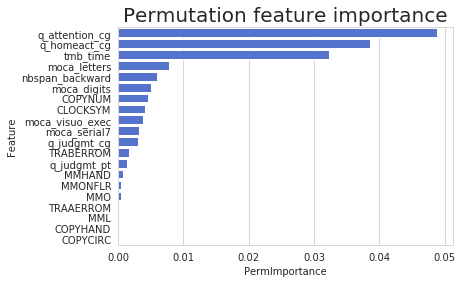

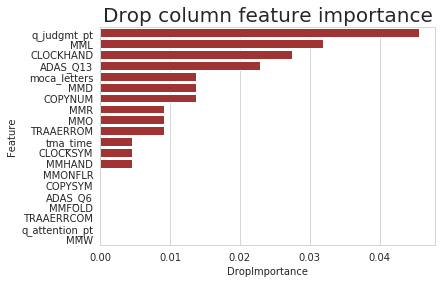

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_exe_2 = ehr_analyses(adni_exe, adni_y2)
ehr_exe_2.to_csv(f'{dir}/Output/ehr_exe_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_exe_2 = ehr_feature(adni_exe, adni_y2)
features_exe_2.to_csv(f'{dir}/Output/features_exe_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_exe_3 = ehr_analyses3(adni_exe, adni_y3)
# ehr_exe_3.to_csv(f'{dir}/Output/ehr_exe_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_exe_3 = ehr_feature(adni_exe, adni_y3)
# features_exe_3.to_csv(f'{dir}/Output/features_exe_3.csv', index=False)

### All above cognitive domain features

In [0]:
all = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall','ADAS_Q4','MMBALLDL', 
       'MMFLAGDL', 'MMTREEDL', 'LDELTOTAL', 'AVDEL30MIN', 
       'AVDELTOT', 'AVDELERR2','q_memory_pt','q_memory_cg',
       'moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg',
       'moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg',
       'moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','ADAS_Q2',
       'ADAS_Q5','ADAS_Q10','ADAS_Q11','ADAS_Q12','MMBALL', 'MMFLAG', 'MMTREE',
       'MMWATCH', 'MMPENCIL','MMREPEAT','MMREAD', 'MMWRITE',
       'CATANIMSC', 'CATVEGESC', 'q_language_pt','q_language_cg']
adni_all = adni_X.loc[:,all]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[300  84]
 [ 45 663]]
Accuracy: 	 0.8818681318681318
AUC: 		 0.8588453389830508


              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82       384
         1.0       0.89      0.94      0.91       708

    accuracy                           0.88      1092
   macro avg       0.88      0.86      0.87      1092
weighted avg       0.88      0.88      0.88      1092



~~XGBoost~~
[[308  76]
 [ 54 654]]
Accuracy: 	 0.8809523809523809
AUC: 		 0.8629060734463276


              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83       384
         1.0       0.90      0.92      0.91       708

    accuracy                           0.88      1092
   macro avg       0.87      0.86      0.87      1092
weighted avg       0.88      0.88      0.88      1092



~~Logistic Regression~~
[[316  68]
 [ 71 637]]
Accuracy: 	 0.8727106227106227
AUC: 		 0.8613170903

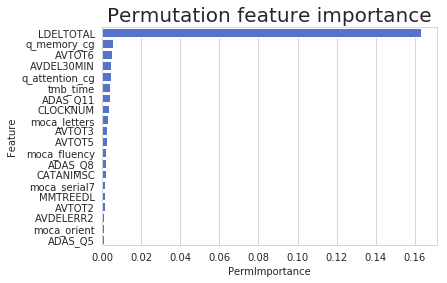

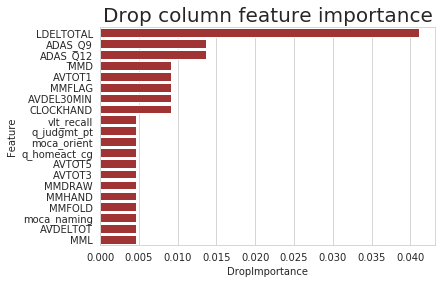

<Figure size 432x288 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_all_2 = ehr_analyses(adni_all, adni_y2)
ehr_all_2.to_csv(f'{dir}/Output/ehr_allcog_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_all_2 = ehr_feature(adni_all, adni_y2)
features_all_2.to_csv(f'{dir}/Output/features_allcog_2_nocdr.csv', index=False)
# #### Predictive Analyses (3)
# print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
# ehr_all_3 = ehr_analyses3(adni_all, adni_y3)
# ehr_all_3.to_csv(f'{dir}/Output/ehr_allcog_3.csv', index=False)
# #### Feature Analyses (3)
# print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
# features_all_3 = ehr_feature(adni_all, adni_y3)
# features_all_3.to_csv(f'{dir}/Output/features_allcog_3.csv', index=False)

# Model comparison - ADNI

## Bimodal

In [0]:
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model

from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split as split

adni_X_train, adni_X_test, adni_y2_train, adni_y2_test = split(adni_X, adni_y2, test_size=0.33, random_state=0)
adni_X_train, adni_X_test, adni_y3_train, adni_y3_test = split(adni_X, adni_y3, test_size=0.33, random_state=0)

In [0]:
adni_mem_train = adni_X_train.loc[:,mem]
adni_stm_train = adni_X_train.loc[:,stm]
adni_ltm_train = adni_X_train.loc[:,ltm]

adni_exe_train = adni_X_train.loc[:,exe]
adni_att_train = adni_X_train.loc[:,att]
adni_exf_train = adni_X_train.loc[:,exf]
adni_vis_train = adni_X_train.loc[:,vis]

adni_lng_train = adni_X_train.loc[:,lng]

adni_mem_test = adni_X_test.loc[:,mem]
adni_stm_test = adni_X_test.loc[:,stm]
adni_ltm_test = adni_X_test.loc[:,ltm]

adni_exe_test = adni_X_test.loc[:,exe]
adni_att_test = adni_X_test.loc[:,att]
adni_exf_test = adni_X_test.loc[:,exf]
adni_vis_test = adni_X_test.loc[:,vis]

adni_lng_test = adni_X_test.loc[:,lng]

adni_all_train = adni_X_train.loc[:,all]
adni_all_test = adni_X_test.loc[:,all]

In [0]:
adni_all_train.shape[1]

103

### Three category model (Memory, EF, Language)

In [0]:
len_mem = adni_mem_train.shape[1]
len_exe = adni_exe_train.shape[1]
len_lng = adni_lng_train.shape[1]

In [0]:
inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
# dense_mem = Dense(10, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
# dense_exe = Dense(10, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_mem,out_exe,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng], outputs=outputs)

model.summary()

W0624 18:53:39.948744 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 18:53:39.951443 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 18:53:39.957221 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 18:53:39.976486 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 18:53:39.985841 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 105)          4200        input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_mem_train, adni_exe_train, adni_lng_train], adni_y2_train, batch_size=1000, epochs=2000, validation_split=0.2)

In [0]:
model.evaluate([adni_mem_test, adni_exe_test, adni_lng_test], adni_y2_test)

361/361 [==============================] - 0s 71us/step


[0.08760812465318187, 0.8808864265927978]

In [0]:
y_pred = model.predict([adni_mem_test, adni_exe_test, adni_lng_test])

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8808864265927978
AUC: 		 0.9505096566523605
Kappa: 		 0.7464514969864267
F1: 		 0.9046563192904656


[[114  14]
 [ 29 204]]


## Unimodal

In [0]:
from keras.models import Sequential

model = Sequential()
model.add(Dense(105, activation='relu', input_dim=103))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(adni_all_train, adni_y2_train, batch_size=1000, epochs=2000, validation_split=0.2)

In [0]:
model.evaluate(adni_all_test, adni_y2_test)

361/361 [==============================] - 0s 54us/step


[0.09051830117226968, 0.8753462603878116]

In [0]:
y_pred = model.predict(adni_all_test)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8753462603878116
AUC: 		 0.9422947961373391
Kappa: 		 0.7309673252405479
F1: 		 0.9019607843137255


[[109  19]
 [ 26 207]]


## RF

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_all_train, adni_y2_train.values.ravel())

y2_pred = clf.predict(adni_all_test)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8753462603878116
AUC: 		 0.9422947961373391
Kappa: 		 0.7309673252405479
F1: 		 0.9019607843137255


[[109  19]
 [ 26 207]]


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

cv=cv = StratifiedKFold(n_splits=5)

mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)

y_pred = cross_val_predict(mlp, adni_all_test, adni_y2_test.values.ravel(), cv=cv)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.9279778393351801
AUC: 		 0.9248424087982833
Kappa: 		 0.8437437570753147
F1: 		 0.9437229437229437


[[117  11]
 [ 15 218]]


## Integrative Approaches

In [0]:
df_adni = pd.read_csv(f'{dir}/Data/imp_adni_all.csv')
df_adni = df_adni.loc[df_adni['VISCODE']==1]

In [0]:
df_adni['mmse_total'] = df_adni[['MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW']].sum(axis=1)
df_adni['ECOG_pt'] = df_adni[['MEM1_pt', 'MEM2_pt', 'MEM3_pt', 'MEM4_pt',
       'MEM5_pt', 'MEM6_pt', 'MEM7_pt', 'MEM8_pt', 'LANG1_pt', 'LANG2_pt',
       'LANG3_pt', 'LANG4_pt', 'LANG5_pt', 'LANG6_pt', 'LANG7_pt',
       'LANG8_pt', 'LANG9_pt', 'VISSPAT1_pt', 'VISSPAT2_pt',
       'VISSPAT3_pt', 'VISSPAT4_pt', 'VISSPAT5_pt', 'VISSPAT6_pt',
       'VISSPAT7_pt', 'VISSPAT8_pt', 'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt',
       'PLAN4_pt', 'PLAN5_pt', 'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt',
       'ORGAN4_pt', 'ORGAN5_pt', 'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt',
       'DIVATT3_pt', 'DIVATT4_pt']].sum(axis=1)
df_adni['ECOG_cg'] = df_adni[['MEM1_cg', 'MEM2_cg', 'MEM3_cg', 'MEM4_cg',
       'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg', 'LANG2_cg',
       'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg', 'LANG7_cg',
       'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']].sum(axis=1)
df_adni['faq_total'] = df_adni[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
df_adni['clock_total'] = df_adni[['CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME']].sum(axis=1)

In [0]:
int_cols = ['moca_total','ADAS_TOTAL13','CDR_global','mmse_total','ECOG_pt',
           'ECOG_cg','faq_total','clock_total']
syn_cols = ['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient','ADAS_Q1', 'ADAS_Q2',
       'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7', 'ADAS_Q8',
       'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12', 'ADAS_Q13',
       'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10', 'MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW','CDR_memory', 'CDR_orient', 'CDR_judge', 'CDR_comm',
       'CDR_home', 'CDR_care','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME','MEM1_pt', 'MEM2_pt', 'MEM3_pt', 'MEM4_pt',
       'MEM5_pt', 'MEM6_pt', 'MEM7_pt', 'MEM8_pt', 'LANG1_pt', 'LANG2_pt',
       'LANG3_pt', 'LANG4_pt', 'LANG5_pt', 'LANG6_pt', 'LANG7_pt',
       'LANG8_pt', 'LANG9_pt', 'VISSPAT1_pt', 'VISSPAT2_pt',
       'VISSPAT3_pt', 'VISSPAT4_pt', 'VISSPAT5_pt', 'VISSPAT6_pt',
       'VISSPAT7_pt', 'VISSPAT8_pt', 'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt',
       'PLAN4_pt', 'PLAN5_pt', 'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt',
       'ORGAN4_pt', 'ORGAN5_pt', 'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt',
       'DIVATT3_pt', 'DIVATT4_pt','MEM1_cg', 'MEM2_cg', 'MEM3_cg', 'MEM4_cg',
       'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg', 'LANG2_cg',
       'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg', 'LANG7_cg',
       'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']
adni_int = df_adni.loc[:,int_cols]
adni_syn = df_adni.loc[:,syn_cols]
adni_y2 = pd.read_csv(f'{dir}/Data/adni_y2.csv')
adni_y3 = pd.read_csv(f'{dir}/Data/adni_y3.csv')

### Random Forest comparison

In [0]:
ehr_analyses(adni_int, adni_y2)

~~Random Forest~~
[[363  21]
 [ 30 678]]
Accuracy: 	 0.9532967032967034
AUC: 		 0.951469809322034
Kappa: 		 0.8981231478432664
F1 score: 	 0.9637526652452025


~~XGBoost~~
[[365  19]
 [ 30 678]]
Accuracy: 	 0.9551282051282052
AUC: 		 0.9540739759887007
Kappa: 		 0.90223420816067
F1 score: 	 0.9651245551601424


~~Logistic Regression~~
[[345  39]
 [ 40 668]]
Accuracy: 	 0.9276556776556777
AUC: 		 0.9209701624293785
Kappa: 		 0.8414389377798364
F1 score: 	 0.9441696113074204


~~SVM~~
[[370  14]
 [ 29 679]]
Accuracy: 	 0.9606227106227107
AUC: 		 0.9612906073446327
Kappa: 		 0.9144082070127086
F1 score: 	 0.9693076374018557


~~MLP~~
[[295  89]
 [ 95 613]]
Accuracy: 	 0.8315018315018315
AUC: 		 0.8170241878531073
Kappa: 		 0.631789594053745
F1 score: 	 0.8695035460992907




,analysis,mean accuracy,AUC
0,Random Forest,0.953297,0.951470
1,XGBoost,0.955128,0.954074
2,LogRegression,0.927656,0.920970
3,SVM,0.960623,0.961291
4,MLP,0.831502,0.817024


In [0]:
ehr_analyses(adni_syn, adni_y2)

~~Random Forest~~
[[365  19]
 [ 29 679]]
Accuracy: 	 0.9560439560439561
AUC: 		 0.9547801906779662
Kappa: 		 0.9041726997499013
F1 score: 	 0.9658605974395449


~~XGBoost~~
[[368  16]
 [ 29 679]]
Accuracy: 	 0.9587912087912088
AUC: 		 0.9586864406779662
Kappa: 		 0.9103212666710465
F1 score: 	 0.9679258731290092


~~Logistic Regression~~
[[326  58]
 [ 75 633]]
Accuracy: 	 0.8782051282051282
AUC: 		 0.8715130649717515
Kappa: 		 0.7355749273557493
F1 score: 	 0.9049320943531093


~~SVM~~
[[354  30]
 [ 38 670]]
Accuracy: 	 0.9377289377289377
AUC: 		 0.9341013418079096
Kappa: 		 0.8640836408364083
F1 score: 	 0.9517045454545454


~~MLP~~
[[304  80]
 [ 86 622]]
Accuracy: 	 0.847985347985348
AUC: 		 0.8350988700564971
Kappa: 		 0.6678101772441395
F1 score: 	 0.8822695035460992




,analysis,mean accuracy,AUC
0,Random Forest,0.956044,0.954780
1,XGBoost,0.958791,0.958686
2,LogRegression,0.878205,0.871513
3,SVM,0.937729,0.934101
4,MLP,0.847985,0.835099


In [0]:
ehr_analyses3(adni_int, adni_y3)

~~Random Forest~~
[[364  20   0]
 [ 28 464  28]
 [  2  49 137]]
Accuracy: 	 0.8836996336996337
Kappa: 		 0.8107963568298526


~~XGBoost~~
[[366  17   1]
 [ 28 468  24]
 [  2  44 142]]
Accuracy: 	 0.8937728937728938
Kappa: 		 0.827404472397687


~~Logistic Regression~~
[[352  29   3]
 [ 27 453  40]
 [  1  52 135]]
Accuracy: 	 0.8608058608058609
Kappa: 		 0.7742942616263258


~~SVM~~
[[375   9   0]
 [ 27 454  39]
 [  2  46 140]]
Accuracy: 	 0.8873626373626373
Kappa: 		 0.8182452949677671


~~MLP~~
[[295  88   1]
 [ 95 390  35]
 [  0  61 127]]
Accuracy: 	 0.7435897435897436
Kappa: 		 0.5821695044958868




,analysis,mean accuracy
0,Random Forest,0.883700
1,Random Forest,0.893773
2,Random Forest,0.860806
3,Random Forest,0.887363
4,Random Forest,0.743590


In [0]:
ehr_analyses3(adni_syn, adni_y3)

~~Random Forest~~
[[365  19   0]
 [ 27 471  22]
 [  2  46 140]]
Accuracy: 	 0.8937728937728938
Kappa: 		 0.8269489284035891


~~XGBoost~~
[[364  20   0]
 [ 27 472  21]
 [  2  45 141]]
Accuracy: 	 0.8946886446886447
Kappa: 		 0.828408867318161


~~Logistic Regression~~
[[333  50   1]
 [ 66 419  35]
 [  2  47 139]]
Accuracy: 	 0.8159340659340659
Kappa: 		 0.7022868458888316


~~SVM~~
[[356  27   1]
 [ 34 441  45]
 [  3  42 143]]
Accuracy: 	 0.8608058608058609
Kappa: 		 0.7759455738236009


~~MLP~~
[[301  82   1]
 [ 89 389  42]
 [  2  48 138]]
Accuracy: 	 0.7582417582417582
Kappa: 		 0.6093806739039711




,analysis,mean accuracy
0,Random Forest,0.893773
1,Random Forest,0.894689
2,Random Forest,0.815934
3,Random Forest,0.860806
4,Random Forest,0.758242


## Physician cutoff ranges procedure

Will only use paired features due to increased complexity of manually assigning splits. See below

# Domains - Paired

In [0]:
adni_pair_X = pd.read_csv(f'{dir}/Data/adni_pair_X.csv')
clinic_pair_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_X.csv')

adni_pair_y2 = pd.read_csv(f'{dir}/Data/adni_pair_y2.csv')
adni_pair_y3 = pd.read_csv(f'{dir}/Data/adni_pair_y3.csv')

clinic_pair_y2 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y2.csv', header=None)
clinic_pair_y3 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y3.csv', header=None)

## Domains 

### Short Term Memory


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[103  22]
 [ 29 149]]
Accuracy: 	 0.8316831683168316
AUC: 		 0.8305393258426967


              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       125
         1.0       0.87      0.84      0.85       178

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



~~XGBoost~~
[[104  21]
 [ 30 148]]
Accuracy: 	 0.8316831683168316
AUC: 		 0.8317303370786516


              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       125
         1.0       0.88      0.83      0.85       178

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



~~MLP~~
[[104  21]
 [  8 170]]
Accuracy: 	 0.9042904290429042
AUC: 		 0.8935280898876404


       

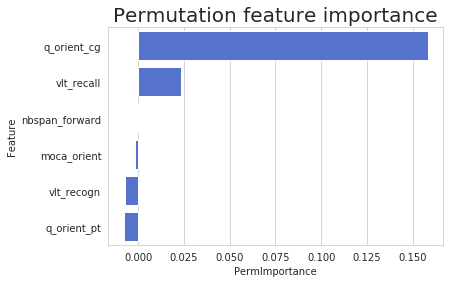

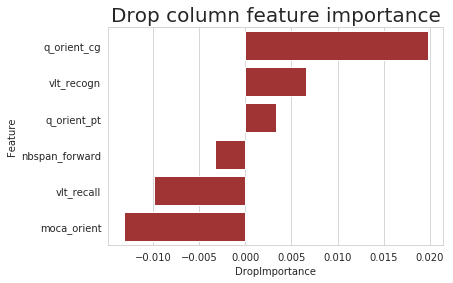

<Figure size 432x288 with 0 Axes>

In [0]:
stm = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg']

adni_stm = adni_pair_X.loc[:,stm]
clinic_stm = clinic_pair_X.loc[:,stm]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_stm_2 = paired_analyses(adni_stm, adni_pair_y2, clinic_stm, clinic_pair_y2)
pair_ehr_stm_2.to_csv(f'{dir}/Output/pair_ehr_stm_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_stm_2 = paired_feature(adni_stm, adni_pair_y2, clinic_stm, clinic_pair_y2)
pair_features_stm_2.to_csv(f'{dir}/Output/pair_features_stm_2_nocdr.csv', index=False)


### Long Term (delay) Memory


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 81  44]
 [ 49 129]]
Accuracy: 	 0.693069306930693
AUC: 		 0.6863595505617978


              precision    recall  f1-score   support

         0.0       0.62      0.65      0.64       125
         1.0       0.75      0.72      0.74       178

    accuracy                           0.69       303
   macro avg       0.68      0.69      0.69       303
weighted avg       0.70      0.69      0.69       303



~~XGBoost~~
[[116   9]
 [ 43 135]]
Accuracy: 	 0.8283828382838284
AUC: 		 0.8432134831460675


              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82       125
         1.0       0.94      0.76      0.84       178

    accuracy                           0.83       303
   macro avg       0.83      0.84      0.83       303
weighted avg       0.85      0.83      0.83       303



~~MLP~~
[[117   8]
 [ 66 112]]
Accuracy: 	 0.7557755775577558
AUC: 		 0.7826067415730337


        

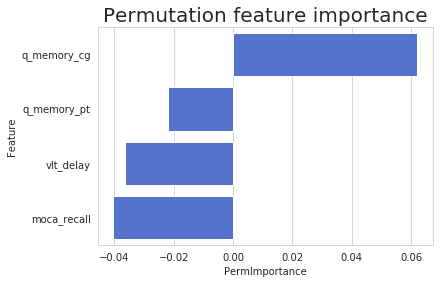

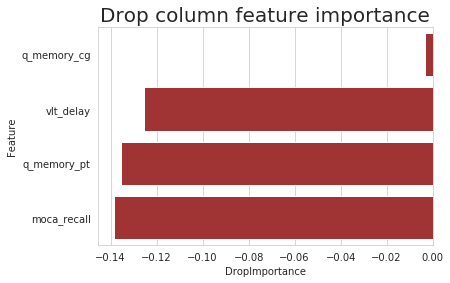

<Figure size 432x288 with 0 Axes>

In [0]:

ltm = ['moca_recall', 'vlt_delay', 'q_memory_pt','q_memory_cg']
adni_ltm = adni_pair_X.loc[:,ltm]
clinic_ltm = clinic_pair_X.loc[:,ltm]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_ltm_2 = paired_analyses(adni_ltm, adni_pair_y2, clinic_ltm, clinic_pair_y2)
pair_ehr_ltm_2.to_csv(f'{dir}/Output/pair_ehr_ltm_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_ltm_2 = paired_feature(adni_ltm, adni_pair_y2, clinic_ltm, clinic_pair_y2)
pair_features_ltm_2.to_csv(f'{dir}/Output/pair_features_ltm_2_nocdr.csv', index=False)


### Attention


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[119   6]
 [ 38 140]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8692584269662922


              precision    recall  f1-score   support

         0.0       0.76      0.95      0.84       125
         1.0       0.96      0.79      0.86       178

    accuracy                           0.85       303
   macro avg       0.86      0.87      0.85       303
weighted avg       0.88      0.85      0.86       303



~~XGBoost~~
[[119   6]
 [ 38 140]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8692584269662922


              precision    recall  f1-score   support

         0.0       0.76      0.95      0.84       125
         1.0       0.96      0.79      0.86       178

    accuracy                           0.85       303
   macro avg       0.86      0.87      0.85       303
weighted avg       0.88      0.85      0.86       303



~~MLP~~
[[ 80  45]
 [ 42 136]]
Accuracy: 	 0.7128712871287128
AUC: 		 0.7020224719101124


       

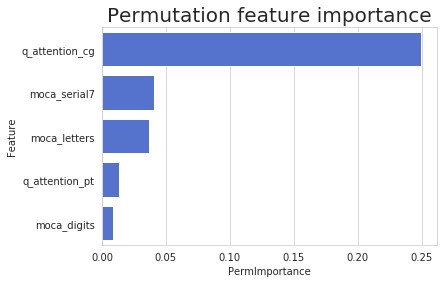

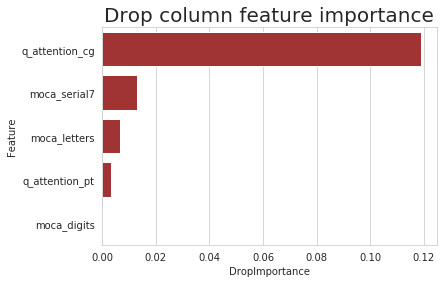

<Figure size 432x288 with 0 Axes>

In [0]:
att = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg']
adni_att = adni_pair_X.loc[:,att]
clinic_att = clinic_pair_X.loc[:,att]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_att_2 = paired_analyses(adni_att, adni_pair_y2, clinic_att, clinic_pair_y2)
pair_ehr_att_2.to_csv(f'{dir}/Output/pair_ehr_att_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_att_2 = paired_feature(adni_att, adni_pair_y2, clinic_att, clinic_pair_y2)
pair_features_att_2.to_csv(f'{dir}/Output/pair_features_att_2_nocdr.csv', index=False)


### Executive Functioning


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[120   5]
 [ 65 113]]
Accuracy: 	 0.768976897689769
AUC: 		 0.7974157303370786


              precision    recall  f1-score   support

         0.0       0.65      0.96      0.77       125
         1.0       0.96      0.63      0.76       178

    accuracy                           0.77       303
   macro avg       0.80      0.80      0.77       303
weighted avg       0.83      0.77      0.77       303



~~XGBoost~~
[[122   3]
 [ 67 111]]
Accuracy: 	 0.768976897689769
AUC: 		 0.7997977528089888


              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       125
         1.0       0.97      0.62      0.76       178

    accuracy                           0.77       303
   macro avg       0.81      0.80      0.77       303
weighted avg       0.84      0.77      0.77       303



~~MLP~~
[[  0 125]
 [  3 175]]
Accuracy: 	 0.5775577557755776
AUC: 		 0.49157303370786515


        

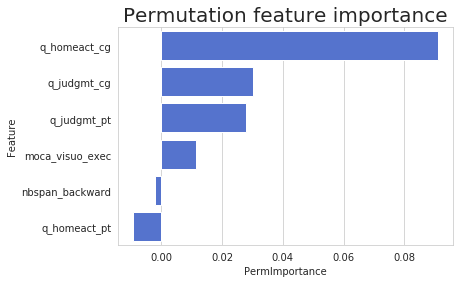

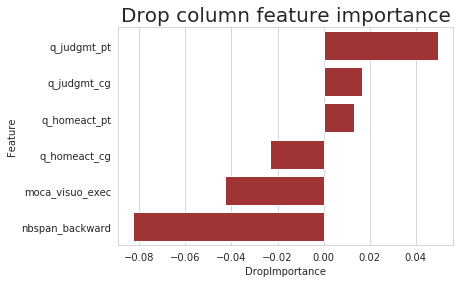

<Figure size 432x288 with 0 Axes>

In [0]:
exf = ['moca_visuo_exec','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_pair_X.loc[:,exf]
clinic_exf = clinic_pair_X.loc[:,exf]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_exf_2 = paired_analyses(adni_exf, adni_pair_y2, clinic_exf, clinic_pair_y2)
pair_ehr_exf_2.to_csv(f'{dir}/Output/pair_ehr_exf_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_exf_2 = paired_feature(adni_exf, adni_pair_y2, clinic_exf, clinic_pair_y2)
pair_features_exf_2.to_csv(f'{dir}/Output/pair_features_exf_2_nocdr.csv', index=False)


### Visuospatial


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[  8 117]
 [  4 174]]
Accuracy: 	 0.6006600660066007
AUC: 		 0.5207640449438202


              precision    recall  f1-score   support

         0.0       0.67      0.06      0.12       125
         1.0       0.60      0.98      0.74       178

    accuracy                           0.60       303
   macro avg       0.63      0.52      0.43       303
weighted avg       0.63      0.60      0.48       303



~~XGBoost~~
[[  0 125]
 [  0 178]]
Accuracy: 	 0.5874587458745875
AUC: 		 0.5


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       125
         1.0       0.59      1.00      0.74       178

    accuracy                           0.59       303
   macro avg       0.29      0.50      0.37       303
weighted avg       0.35      0.59      0.43       303





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


~~MLP~~
[[  0 125]
 [  0 178]]
Accuracy: 	 0.5874587458745875
AUC: 		 0.5


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       125
         1.0       0.59      1.00      0.74       178

    accuracy                           0.59       303
   macro avg       0.29      0.50      0.37       303
weighted avg       0.35      0.59      0.43       303




~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


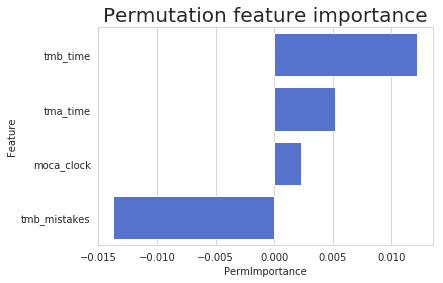

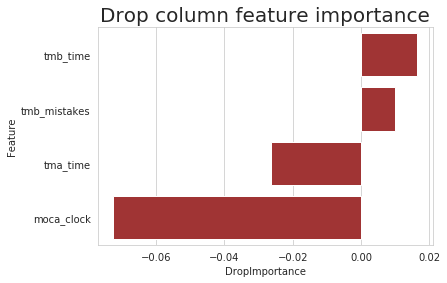

<Figure size 432x288 with 0 Axes>

In [0]:
vis = ['moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_vis = adni_pair_X.loc[:,vis]
clinic_vis = clinic_pair_X.loc[:,vis]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_vis_2 = paired_analyses(adni_vis, adni_pair_y2, clinic_vis, clinic_pair_y2)
pair_ehr_vis_2.to_csv(f'{dir}/Output/pair_ehr_vis_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_vis_2 = paired_feature(adni_vis, adni_pair_y2, clinic_vis, clinic_pair_y2)
pair_features_vis_2.to_csv(f'{dir}/Output/pair_features_vis_2_nocdr.csv', index=False)


### Language


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 75  50]
 [ 40 138]]
Accuracy: 	 0.7029702970297029
AUC: 		 0.6876404494382022


              precision    recall  f1-score   support

         0.0       0.65      0.60      0.63       125
         1.0       0.73      0.78      0.75       178

    accuracy                           0.70       303
   macro avg       0.69      0.69      0.69       303
weighted avg       0.70      0.70      0.70       303



~~XGBoost~~
[[108  17]
 [ 29 149]]
Accuracy: 	 0.8481848184818482
AUC: 		 0.8505393258426965


              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       125
         1.0       0.90      0.84      0.87       178

    accuracy                           0.85       303
   macro avg       0.84      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303



~~MLP~~
[[123   2]
 [ 40 138]]
Accuracy: 	 0.8613861386138614
AUC: 		 0.8796404494382022


       

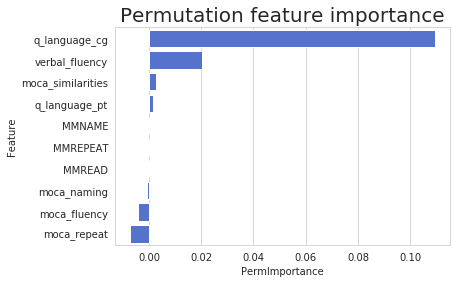

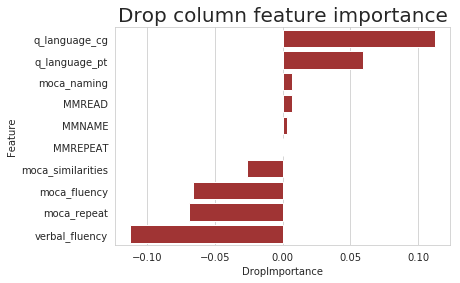

<Figure size 432x288 with 0 Axes>

In [0]:
lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD',
       'verbal_fluency', 'q_language_pt','q_language_cg']
adni_lng = adni_pair_X.loc[:,lng]
clinic_lng = clinic_pair_X.loc[:,lng]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_lng_2 = paired_analyses(adni_lng, adni_pair_y2, clinic_lng, clinic_pair_y2)
pair_ehr_lng_2.to_csv(f'{dir}/Output/pair_ehr_lng_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_lng_2 = paired_feature(adni_lng, adni_pair_y2, clinic_lng, clinic_pair_y2)
pair_features_lng_2.to_csv(f'{dir}/Output/pair_features_lng_2_nocdr.csv', index=False)

### All memory



~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[114  11]
 [ 44 134]]
Accuracy: 	 0.8184818481848185
AUC: 		 0.8324044943820224


              precision    recall  f1-score   support

         0.0       0.72      0.91      0.81       125
         1.0       0.92      0.75      0.83       178

    accuracy                           0.82       303
   macro avg       0.82      0.83      0.82       303
weighted avg       0.84      0.82      0.82       303



~~XGBoost~~
[[116   9]
 [ 43 135]]
Accuracy: 	 0.8283828382838284
AUC: 		 0.8432134831460675


              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82       125
         1.0       0.94      0.76      0.84       178

    accuracy                           0.83       303
   macro avg       0.83      0.84      0.83       303
weighted avg       0.85      0.83      0.83       303



~~MLP~~
[[116   9]
 [ 55 123]]
Accuracy: 	 0.7887788778877888
AUC: 		 0.8095056179775281


       

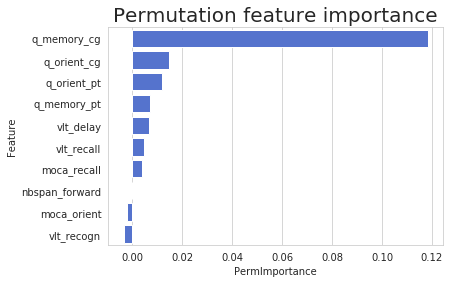

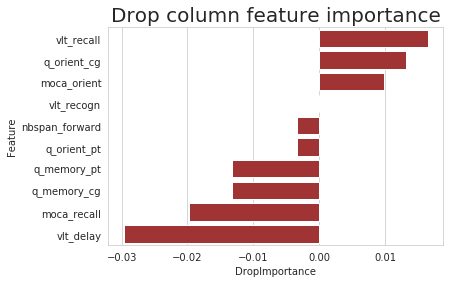

<Figure size 432x288 with 0 Axes>

In [0]:
mem = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg']
adni_mem = adni_pair_X.loc[:,mem]
clinic_mem = clinic_pair_X.loc[:,mem]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_mem_2 = paired_analyses(adni_mem, adni_pair_y2, clinic_mem, clinic_pair_y2)
pair_ehr_mem_2.to_csv(f'{dir}/Output/pair_ehr_mem_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_mem_2 = paired_feature(adni_mem, adni_pair_y2, clinic_mem, clinic_pair_y2)
pair_features_mem_2.to_csv(f'{dir}/Output/pair_features_mem_2_nocdr.csv', index=False)

### All executive funcitoning



~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 94  31]
 [ 24 154]]
Accuracy: 	 0.8184818481848185
AUC: 		 0.8085842696629214


              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       125
         1.0       0.83      0.87      0.85       178

    accuracy                           0.82       303
   macro avg       0.81      0.81      0.81       303
weighted avg       0.82      0.82      0.82       303



~~XGBoost~~
[[108  17]
 [ 25 153]]
Accuracy: 	 0.8613861386138614
AUC: 		 0.8617752808988765


              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       125
         1.0       0.90      0.86      0.88       178

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.86      0.86      0.86       303



~~MLP~~
[[ 46  79]
 [ 12 166]]
Accuracy: 	 0.6996699669966997
AUC: 		 0.6502921348314605


       

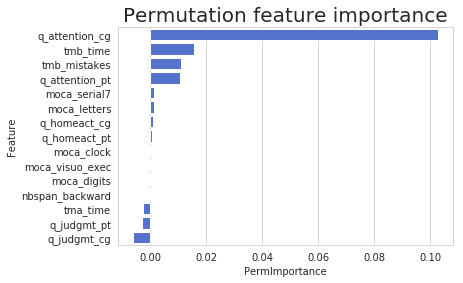

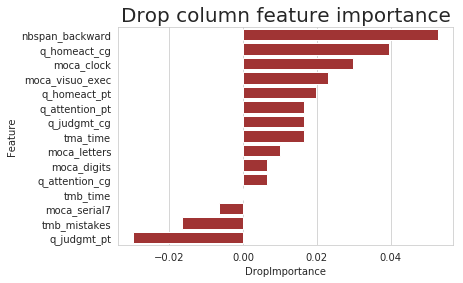

<Figure size 432x288 with 0 Axes>

In [0]:
exe = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec','nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_exe = adni_pair_X.loc[:,exe]
clinic_exe = clinic_pair_X.loc[:,exe]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_exe_2 = paired_analyses(adni_exe, adni_pair_y2, clinic_exe, clinic_pair_y2)
pair_ehr_exe_2.to_csv(f'{dir}/Output/pair_ehr_exe_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_exe_2 = paired_feature(adni_exe, adni_pair_y2, clinic_exe, clinic_pair_y2)
pair_features_exe_2.to_csv(f'{dir}/Output/pair_features_exe_2_nocdr.csv', index=False)

### All above cognitive domain features


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[113  12]
 [ 42 136]]
Accuracy: 	 0.8217821782178217
AUC: 		 0.8340224719101124


              precision    recall  f1-score   support

         0.0       0.73      0.90      0.81       125
         1.0       0.92      0.76      0.83       178

    accuracy                           0.82       303
   macro avg       0.82      0.83      0.82       303
weighted avg       0.84      0.82      0.82       303



~~XGBoost~~
[[125   0]
 [ 48 130]]
Accuracy: 	 0.8415841584158416
AUC: 		 0.8651685393258427


              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       125
         1.0       1.00      0.73      0.84       178

    accuracy                           0.84       303
   macro avg       0.86      0.87      0.84       303
weighted avg       0.89      0.84      0.84       303



~~MLP~~
[[117   8]
 [ 51 127]]
Accuracy: 	 0.8052805280528053
AUC: 		 0.8247415730337078


       

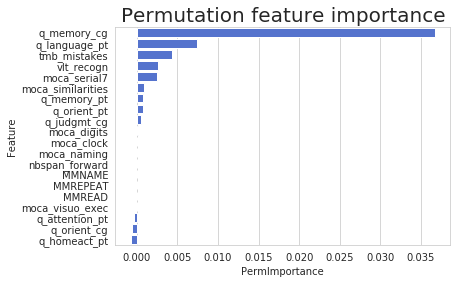

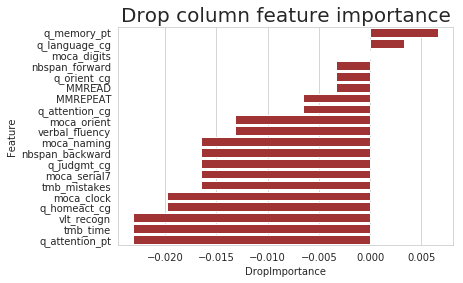

<Figure size 432x288 with 0 Axes>

In [0]:
all = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD',
       'verbal_fluency', 'q_language_pt','q_language_cg',
       'moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec',
       'nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_all = adni_pair_X.loc[:,all]
clinic_all = clinic_pair_X.loc[:,all]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_all_2 = paired_analyses(adni_all, adni_pair_y2, clinic_all, clinic_pair_y2)
pair_ehr_all_2.to_csv(f'{dir}/Output/pair_ehr_all_2_nocdr.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_all_2 = paired_feature(adni_all, adni_pair_y2, clinic_all, clinic_pair_y2)
pair_features_all_2.to_csv(f'{dir}/Output/pair_features_all_2_nocdr.csv', index=False)

# Model comparison - Paired

In [0]:
adni_pair_X = pd.read_csv(f'{dir}/Data/adni_pair_X.csv')
clinic_pair_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_X.csv')

adni_pair_y2 = pd.read_csv(f'{dir}/Data/adni_pair_y2.csv')
# adni_pair_y3 = pd.read_csv(f'{dir}/Data/adni_pair_y3.csv')

clinic_pair_y2 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y2.csv', header=None, names=['Impaired'])
# clinic_pair_y3 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y3.csv', header=None)

In [0]:
stm = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg']
adni_stm = adni_pair_X.loc[:,stm]
clinic_stm = clinic_pair_X.loc[:,stm]

ltm = ['moca_recall', 'vlt_delay', 'q_memory_pt','q_memory_cg']
adni_ltm = adni_pair_X.loc[:,ltm]
clinic_ltm = clinic_pair_X.loc[:,ltm]

att = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg']
adni_att = adni_pair_X.loc[:,att]
clinic_att = clinic_pair_X.loc[:,att]

exf = ['moca_visuo_exec','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_pair_X.loc[:,exf]
clinic_exf = clinic_pair_X.loc[:,exf]

vis = ['moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_vis = adni_pair_X.loc[:,vis]
clinic_vis = clinic_pair_X.loc[:,vis]

lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD',
       'verbal_fluency', 'q_language_pt','q_language_cg']
adni_lng = adni_pair_X.loc[:,lng]
clinic_lng = clinic_pair_X.loc[:,lng]

mem = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg']
adni_mem = adni_pair_X.loc[:,mem]
clinic_mem = clinic_pair_X.loc[:,mem]

exe = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec',
       'nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_exe = adni_pair_X.loc[:,exe]
clinic_exe = clinic_pair_X.loc[:,exe]

all = ['moca_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD',
       'verbal_fluency', 'q_language_pt','q_language_cg',
       'moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec',
       'nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_all = adni_pair_X.loc[:,all]
clinic_all = clinic_pair_X.loc[:,all]

In [0]:
faq = ['faq1', 'faq2', 'faq3', 'faq4', 'faq5', 'faq6',
       'faq7', 'faq8', 'faq9', 'faq10']
adni_faq = adni_pair_X.loc[:,faq]
clinic_faq = clinic_pair_X.loc[:,faq]

mnt = ['hach8', 'npi1_sev', 'npi2_sev', 'npi3_sev', 'npi4_sev',
       'npi5_sev', 'npi6_sev', 'npi7_sev', 'npi8_sev', 'npi9_sev',
       'npi10_sev', 'npi11_sev', 'npi12_sev']
adni_mnt = adni_pair_X.loc[:,mnt]
clinic_mnt = clinic_pair_X.loc[:,mnt]

## Bimodal

In [0]:
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model

from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
adni_mem = adni_pair_X.loc[:,mem]
adni_stm = adni_pair_X.loc[:,stm]
adni_ltm = adni_pair_X.loc[:,ltm]

adni_exe = adni_pair_X.loc[:,exe]
adni_att = adni_pair_X.loc[:,att]
adni_exf = adni_pair_X.loc[:,exf]
adni_vis = adni_pair_X.loc[:,vis]

adni_lng = adni_pair_X.loc[:,lng]

adni_allcog = adni_pair_X.loc[:,all]


clinic_mem = clinic_pair_X.loc[:,mem]
clinic_stm = clinic_pair_X.loc[:,stm]
clinic_ltm = clinic_pair_X.loc[:,ltm]

clinic_exe = clinic_pair_X.loc[:,exe]
clinic_att = clinic_pair_X.loc[:,att]
clinic_exf = clinic_pair_X.loc[:,exf]
clinic_vis = clinic_pair_X.loc[:,vis]

clinic_lng = clinic_pair_X.loc[:,lng]

clinic_allcog = clinic_pair_X.loc[:,all]

### Three category model (Memory, EF, Language)

In [0]:
len_mem = adni_mem.shape[1]
len_exe = adni_exe.shape[1]
len_lng = adni_lng.shape[1]


inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
# dense_mem = Dense(10, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
# dense_exe = Dense(10, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_mem,out_exe,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng], outputs=outputs)

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_mem, adni_exe, adni_lng], adni_pair_y2, batch_size=1000, 
          epochs=2000, validation_split=0.2)

In [0]:
model.evaluate([clinic_mem, clinic_exe, clinic_lng], clinic_pair_y2) #3000 epochs

In [0]:
from sklearn.metrics import classification_report

y_pred = model.predict([clinic_mem, clinic_exe, clinic_lng])

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('\n')
print(classification_report(clinic_pair_y2, np.rint(y_pred), digits=3))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8778877887788779
AUC: 		 0.9241797752808989


              precision    recall  f1-score   support

         0.0      0.849     0.856     0.853       125
         1.0      0.898     0.893     0.896       178

    accuracy                          0.878       303
   macro avg      0.874     0.875     0.874       303
weighted avg      0.878     0.878     0.878       303



[[107  18]
 [ 19 159]]


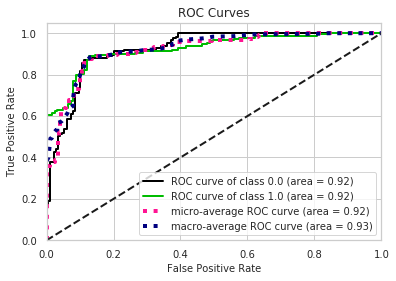

In [0]:
clinic_proba = model.predict([clinic_mem, clinic_exe, clinic_lng])
clinic_proba = np.append(np.subtract(1, clinic_proba),clinic_proba, axis=1)
roc = skplt.metrics.plot_roc(clinic_pair_y2.to_numpy(), clinic_proba)
fig = roc.get_figure()
fig.savefig(f'{dir}/Figures/roc_cog_bi_3cat_88_nocdr.png', dpi=300)

### Six category model

In [0]:
len_stm = adni_stm.shape[1]
len_ltm = adni_ltm.shape[1]
len_att = adni_att.shape[1]
len_exf = adni_exf.shape[1]
len_vis = adni_vis.shape[1]
len_lng = adni_lng.shape[1]


inputs_stm = Input(shape=(len_stm,))
dense_stm = Dense(105, activation='relu')(inputs_stm)
dense_stm = Dropout(0.2)(dense_stm)
dense_stm = Dense(60, activation='relu')(dense_stm)
# dense_stm = Dense(10, activation='relu')(dense_stm)
out_stm = Dense(15, activation='relu')(dense_stm)

inputs_ltm = Input(shape=(len_ltm,))
dense_ltm = Dense(105, activation='relu')(inputs_ltm)
dense_ltm = Dropout(0.2)(dense_ltm)
dense_ltm = Dense(60, activation='relu')(dense_ltm)
# dense_ltm = Dense(10, activation='relu')(dense_ltm)
out_ltm = Dense(15, activation='relu')(dense_ltm)

inputs_att = Input(shape=(len_att,))
dense_att = Dense(105, activation='relu')(inputs_att)
dense_att = Dropout(0.2)(dense_att)
dense_att = Dense(60, activation='relu')(dense_att)
# dense_att = Dense(10, activation='relu')(dense_att)
out_att = Dense(15, activation='relu')(dense_att)

inputs_exf = Input(shape=(len_exf,))
dense_exf = Dense(105, activation='relu')(inputs_exf)
dense_exf = Dropout(0.2)(dense_exf)
dense_exf = Dense(60, activation='relu')(dense_exf)
# dense_exf = Dense(10, activation='relu')(dense_exf)
out_exf = Dense(15, activation='relu')(dense_exf)

inputs_vis = Input(shape=(len_vis,))
dense_vis = Dense(105, activation='relu')(inputs_vis)
dense_vis = Dropout(0.2)(dense_vis)
dense_vis = Dense(60, activation='relu')(dense_vis)
# dense_vis = Dense(10, activation='relu')(dense_vis)
out_vis = Dense(15, activation='relu')(dense_vis)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_stm,out_ltm,out_att,out_exf,out_vis,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_stm, inputs_ltm, inputs_att, inputs_exf, inputs_vis, inputs_lng], outputs=outputs)

# model.summary()
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_stm, adni_ltm, adni_att, adni_exf, adni_vis, adni_lng], adni_pair_y2, batch_size=1000, 
          epochs=2000, validation_split=0.2)

In [0]:
model.evaluate([clinic_stm, clinic_ltm, clinic_att, clinic_exf, clinic_vis, clinic_lng], clinic_pair_y2) #6000 epochs

In [0]:
y_pred = model.predict([clinic_stm, clinic_ltm, clinic_att, clinic_exf, clinic_vis, clinic_lng])

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('\n')
print(classification_report(clinic_pair_y2, np.rint(y_pred), digits=3))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8448844884488449
AUC: 		 0.9319101123595506


              precision    recall  f1-score   support

         0.0      0.753     0.928     0.832       125
         1.0      0.940     0.787     0.856       178

    accuracy                          0.845       303
   macro avg      0.846     0.857     0.844       303
weighted avg      0.863     0.845     0.846       303



[[116   9]
 [ 38 140]]


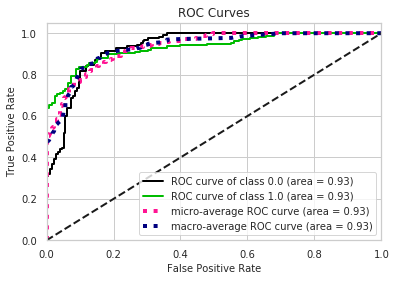

In [0]:
clinic_proba = model.predict([clinic_stm, clinic_ltm, clinic_att, clinic_exf, clinic_vis, clinic_lng])
clinic_proba = np.append(np.subtract(1, clinic_proba),clinic_proba, axis=1)
roc = skplt.metrics.plot_roc(clinic_pair_y2.to_numpy(), clinic_proba)
fig = roc.get_figure()
fig.savefig(f'{dir}/Figures/roc_cog_bi_6cat_85_nocdr.png', dpi=300)

### 3 Cog + FAQ + Physical/Mental + Dem



In [0]:
inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

inputs_faq = Input(shape=(len_faq,))
dense_faq = Dense(105, activation='relu')(inputs_faq)
dense_faq = Dropout(0.2)(dense_faq)
dense_faq = Dense(60, activation='relu')(dense_faq)
out_faq = Dense(15, activation='relu')(dense_faq)

inputs_phm = Input(shape=(len_phm,))
dense_phm = Dense(105, activation='relu')(inputs_phm)
dense_phm = Dropout(0.2)(dense_phm)
dense_phm = Dense(60, activation='relu')(dense_phm)
out_phm = Dense(15, activation='relu')(dense_phm)

inputs_dem = Input(shape=(len_dem,))
dense_dem = Dense(105, activation='relu')(inputs_dem)
dense_dem = Dropout(0.2)(dense_dem)
dense_dem = Dense(60, activation='relu')(dense_dem)
out_dem = Dense(15, activation='relu')(dense_dem)

out_flat = concatenate([out_mem,out_exe,out_lng,out_faq,out_phm,out_dem])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng,inputs_faq,inputs_phm,inputs_dem], outputs=outputs)


model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_pair_mem, adni_pair_exe, adni_pair_lng, adni_pair_faq, adni_pair_phm, adni_pair_dem], df_adni_pair_y2, batch_size=1000, epochs=2500, validation_split=0.2)

In [0]:
model.evaluate([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem],sm_clinic_pair_y2)

303/303 [==============================] - 0s 149us/step


[0.13073293830301896, 0.8580858091710031]

In [0]:
y_pred = model.predict([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem])
print('Accuracy: \t', accuracy_score(sm_clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(sm_clinic_pair_y2, y_pred))
print('\n')
print(classification_report(sm_clinic_pair_y2, np.rint(y_pred), digits=3))
print('\n')
print(confusion_matrix(sm_clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.858085808580858
AUC: 		 0.9047191011235955


              precision    recall  f1-score   support

         0.0      0.831     0.824     0.827       125
         1.0      0.877     0.882     0.880       178

    accuracy                          0.858       303
   macro avg      0.854     0.853     0.853       303
weighted avg      0.858     0.858     0.858       303



[[103  22]
 [ 21 157]]


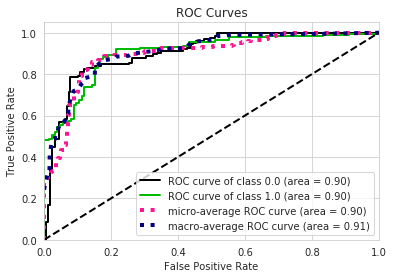

In [0]:
clinic_proba = model.predict([clinic_pair_mem, clinic_pair_exe, clinic_pair_lng, clinic_pair_faq, clinic_pair_phm, clinic_pair_dem])
clinic_proba = np.append(np.subtract(1, clinic_proba),clinic_proba, axis=1)
roc = skplt.metrics.plot_roc(sm_clinic_pair_y2.to_numpy(), clinic_proba)
fig = roc.get_figure()
fig.savefig(f'{dir}/Figures/roc_ehr_bi_6cat_3cog_2_nocdr', dpi=300)

### 3 Cog + FAQ

In [0]:
len_faq = adni_faq.shape[1]

inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

inputs_faq = Input(shape=(len_faq,))
dense_faq = Dense(105, activation='relu')(inputs_faq)
dense_faq = Dropout(0.2)(dense_faq)
dense_faq = Dense(60, activation='relu')(dense_faq)
out_faq = Dense(15, activation='relu')(dense_faq)

out_flat = concatenate([out_mem,out_exe,out_lng,out_faq])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng,inputs_faq], outputs=outputs)


model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_mem, adni_exe, adni_lng, adni_faq], adni_pair_y2, batch_size=1000, epochs=3000, validation_split=0.2)

In [0]:
model.evaluate([clinic_mem, clinic_exe, clinic_lng, clinic_faq],clinic_pair_y2)

303/303 [==============================] - 0s 91us/step


[0.1719834562575463, 0.8811881194020262]

In [0]:
y_pred = model.predict([clinic_mem, clinic_exe, clinic_lng, clinic_faq])
print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('\n')
print(classification_report(clinic_pair_y2, np.rint(y_pred), digits=3))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8811881188118812
AUC: 		 0.9281797752808989


              precision    recall  f1-score   support

         0.0      0.874     0.832     0.852       125
         1.0      0.886     0.916     0.901       178

    accuracy                          0.881       303
   macro avg      0.880     0.874     0.877       303
weighted avg      0.881     0.881     0.881       303



[[104  21]
 [ 15 163]]


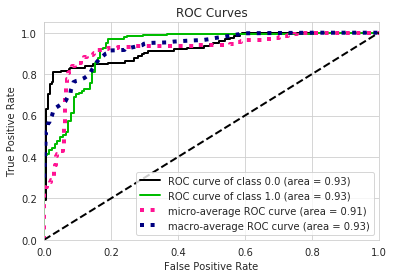

In [0]:
clinic_proba = model.predict([clinic_mem, clinic_exe, clinic_lng, clinic_faq])
clinic_proba = np.append(np.subtract(1, clinic_proba),clinic_proba, axis=1)
roc = skplt.metrics.plot_roc(clinic_pair_y2.to_numpy(), clinic_proba)
fig = roc.get_figure()
fig.savefig(f'{dir}/Figures/roc_ehr_bi_3cog_faq', dpi=300)

## Unimodal

In [0]:
from keras.models import Sequential

model = Sequential()
model.add(Dense(105, activation='relu', input_dim=adni_pair_X.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(adni_pair_X, adni_pair_y2, batch_size=1000, 
          epochs=2000, validation_split=0.2)

In [0]:
model.evaluate(clinic_pair_X, clinic_pair_y2)

303/303 [==============================] - 0s 74us/step


[0.14030219530901894, 0.8712871294997313]

In [0]:
y_pred = model.predict(clinic_pair_X) #11000 epochs

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('\n')
print(classification_report(clinic_pair_y2, np.rint(y_pred), digits=3))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8712871287128713
AUC: 		 0.9185168539325843


              precision    recall  f1-score   support

         0.0      0.858     0.824     0.841       125
         1.0      0.880     0.904     0.892       178

    accuracy                          0.871       303
   macro avg      0.869     0.864     0.866       303
weighted avg      0.871     0.871     0.871       303



[[103  22]
 [ 17 161]]


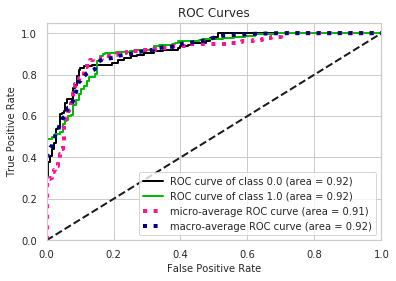

In [0]:
clinic_proba = model.predict(clinic_pair_X)
clinic_proba = np.append(np.subtract(1, clinic_proba),clinic_proba, axis=1)
roc = skplt.metrics.plot_roc(clinic_pair_y2.to_numpy(), clinic_proba)
fig = roc.get_figure()
fig.savefig(f'{dir}/Figures/roc_cog_uni1_nocdr.png', dpi=300)

# Thresholds



## Physician Threshold

- MOCA: < 25 = impaired, <20 = AD
- TrailmakingA: > 45 = impaired, > 80 = AD
- TrailmakingB: > 133 = impaired, >173 = AD
- Verbal fluency: < 13 = impaired, < 7 = AD
- vlt_recall: < 23 = impaired, < 16 = AD
- vlt_delay: < 8 = impaired, < 4 = AD
- QDRS: > 1.5 = MCI  /  > 6 = AD (Galvin, 2015)
- FAQ: >6 = impairment (Teng, 2010)



In [0]:
adni_us_X = pd.read_csv(f'{dir}/Data/adni_pair_unscaled_X.csv')
clinic_us_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_us_X.csv')
adni_us_y2 = pd.read_csv(f'{dir}/Data/adni_pair_us_y2.csv')
adni_us_y3 = pd.read_csv(f'{dir}/Data/adni_pair_us_y3.csv')
clinic_us_y2 = clinic_pair_y2

In [0]:
adni_us_X['faq_total'] = adni_us_X[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
adni_us_X['moca_total'] = adni_us_X[['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient']].sum(axis=1)
adni_us_X['qdrs_total_pt'] = adni_us_X[['q_memory_pt', 'q_orient_pt', 
       'q_judgmt_pt', 'q_outsideact_pt',
       'q_homeact_pt', 'q_language_pt', 'q_attention_pt']].sum(axis=1)
adni_us_X['qdrs_total_cg'] = adni_us_X[['q_memory_cg',
       'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
       'q_language_cg', 'q_attention_cg']].sum(axis=1)
clinic_us_X['faq_total'] = clinic_us_X[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
clinic_us_X['moca_total'] = clinic_us_X[['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient']].sum(axis=1)
clinic_us_X['qdrs_total_pt'] = clinic_us_X[['q_memory_pt', 'q_orient_pt', 
       'q_judgmt_pt', 'q_outsideact_pt',
       'q_homeact_pt', 'q_language_pt', 'q_attention_pt']].sum(axis=1)
clinic_us_X['qdrs_total_cg'] = clinic_us_X[['q_memory_cg',
       'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
       'q_language_cg', 'q_attention_cg']].sum(axis=1)
adni_us_X['nbspan_forward'] = adni_us_X['nbspan_forward']*12
adni_us_X['nbspan_backward'] = adni_us_X['nbspan_backward']*12

In [0]:
adni_us_X['thresh_moca_2'] = adni_us_X['moca_total'].apply(lambda x: 1 if x<=25 else 0)
adni_us_X['thresh_moca_3'] = adni_us_X[['moca_total','thresh_moca_2']].apply(lambda x: 2 if x['moca_total']<=20 else x['thresh_moca_2'], axis=1)
adni_us_X['thresh_tma_2'] = adni_us_X['tma_time'].apply(lambda x: 1 if x>=35 else 0)
adni_us_X['thresh_tma_3'] = adni_us_X[['tma_time','thresh_tma_2']].apply(lambda x: 2 if x['tma_time']>=54 else x['thresh_tma_2'], axis=1)
adni_us_X['thresh_tmb_2'] = adni_us_X['tmb_time'].apply(lambda x: 1 if x>=115 else 0)
adni_us_X['thresh_tmb_3'] = adni_us_X[['tmb_time','thresh_tmb_2']].apply(lambda x: 2 if x['tmb_time']>=154 else x['thresh_tmb_2'], axis=1)
adni_us_X['thresh_verbal_fluency_2'] = adni_us_X['verbal_fluency'].apply(lambda x: 1 if x<=13 else 0)
adni_us_X['thresh_verbal_fluency_3'] = adni_us_X[['verbal_fluency','thresh_verbal_fluency_2']].apply(lambda x: 2 if x['verbal_fluency']<=7 else x['thresh_verbal_fluency_2'], axis=1)
adni_us_X['thresh_vlt_recall_2'] = adni_us_X['vlt_recall'].apply(lambda x: 1 if x<=23 else 0)
adni_us_X['thresh_vlt_recall_3'] = adni_us_X[['vlt_recall','thresh_vlt_recall_2']].apply(lambda x: 2 if x['vlt_recall']<=16 else x['thresh_vlt_recall_2'], axis=1)
adni_us_X['thresh_vlt_delay_2'] = adni_us_X['vlt_delay'].apply(lambda x: 1 if x<=8 else 0)
adni_us_X['thresh_vlt_delay_3'] = adni_us_X[['vlt_delay','thresh_vlt_delay_2']].apply(lambda x: 2 if x['vlt_delay']<=4 else x['thresh_vlt_delay_2'], axis=1)
adni_us_X['thresh_qdrs_pt_2'] = adni_us_X['qdrs_total_pt'].apply(lambda x: 1 if x>=1.5 else 0)
adni_us_X['thresh_qdrs_pt_3'] = adni_us_X[['qdrs_total_pt','thresh_qdrs_pt_2']].apply(lambda x: 2 if x['qdrs_total_pt']>=6 else x['thresh_qdrs_pt_2'], axis=1)
adni_us_X['thresh_qdrs_cg_2'] = adni_us_X['qdrs_total_cg'].apply(lambda x: 1 if x>=1.5 else 0)
adni_us_X['thresh_qdrs_cg_3'] = adni_us_X[['qdrs_total_cg','thresh_qdrs_cg_2']].apply(lambda x: 2 if x['qdrs_total_cg']>=6 else x['thresh_qdrs_cg_2'], axis=1)
adni_us_X['thresh_faq'] = adni_us_X['faq_total'].apply(lambda x: 1 if x>=6 else 0)
adni_thresh = adni_us_X.loc[:,['thresh_moca_2','thresh_tma_2','thresh_verbal_fluency_2','thresh_vlt_recall_2',
                              'thresh_vlt_delay_2','thresh_qdrs_pt_2','thresh_qdrs_cg_2','thresh_faq']]
adni_totals = adni_us_X.loc[:,['faq_total','moca_total','qdrs_total_cg','qdrs_total_pt','tma_time',
                              'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]
adni_separated = adni_us_X.loc[:,['faq1', 'faq2', 'faq3', 'faq4','faq5', 'faq6',
                                  'faq7', 'faq8', 'faq9', 'faq10','moca_visuo_exec', 'moca_clock',
                                  'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
                                  'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
                                  'moca_orient','q_memory_pt', 'q_orient_pt', 
                                  'q_judgmt_pt', 'q_outsideact_pt',
                                  'q_homeact_pt', 'q_language_pt', 'q_attention_pt','q_memory_cg',
                                  'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
                                  'q_language_cg', 'q_attention_cg','tma_time',
                                  'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]

clinic_us_X['thresh_moca_2'] = clinic_us_X['moca_total'].apply(lambda x: 1 if x<=25 else 0)
clinic_us_X['thresh_moca_3'] = clinic_us_X[['moca_total','thresh_moca_2']].apply(lambda x: 2 if x['moca_total']<=20 else x['thresh_moca_2'], axis=1)
clinic_us_X['thresh_tma_2'] = clinic_us_X['tma_time'].apply(lambda x: 1 if x>=35 else 0)
clinic_us_X['thresh_tma_3'] = clinic_us_X[['tma_time','thresh_tma_2']].apply(lambda x: 2 if x['tma_time']>=54 else x['thresh_tma_2'], axis=1)
clinic_us_X['thresh_tmb_2'] = clinic_us_X['tmb_time'].apply(lambda x: 1 if x>=115 else 0)
clinic_us_X['thresh_tmb_3'] = clinic_us_X[['tmb_time','thresh_tmb_2']].apply(lambda x: 2 if x['tmb_time']>=154 else x['thresh_tmb_2'], axis=1)
clinic_us_X['thresh_verbal_fluency_2'] = clinic_us_X['verbal_fluency'].apply(lambda x: 1 if x<=13 else 0)
clinic_us_X['thresh_verbal_fluency_3'] = clinic_us_X[['verbal_fluency','thresh_verbal_fluency_2']].apply(lambda x: 2 if x['verbal_fluency']<=7 else x['thresh_verbal_fluency_2'], axis=1)
clinic_us_X['thresh_vlt_recall_2'] = clinic_us_X['vlt_recall'].apply(lambda x: 1 if x<=23 else 0)
clinic_us_X['thresh_vlt_recall_3'] = clinic_us_X[['vlt_recall','thresh_vlt_recall_2']].apply(lambda x: 2 if x['vlt_recall']<=16 else x['thresh_vlt_recall_2'], axis=1)
clinic_us_X['thresh_vlt_delay_2'] = clinic_us_X['vlt_delay'].apply(lambda x: 1 if x<=8 else 0)
clinic_us_X['thresh_vlt_delay_3'] = clinic_us_X[['vlt_delay','thresh_vlt_delay_2']].apply(lambda x: 2 if x['vlt_delay']<=4 else x['thresh_vlt_delay_2'], axis=1)
clinic_us_X['thresh_qdrs_pt_2'] = clinic_us_X['qdrs_total_pt'].apply(lambda x: 1 if x>=1.5 else 0)
clinic_us_X['thresh_qdrs_pt_3'] = clinic_us_X[['qdrs_total_pt','thresh_qdrs_pt_2']].apply(lambda x: 2 if x['qdrs_total_pt']>=6 else x['thresh_qdrs_pt_2'], axis=1)
clinic_us_X['thresh_qdrs_cg_2'] = clinic_us_X['qdrs_total_cg'].apply(lambda x: 1 if x>=1.5 else 0)
clinic_us_X['thresh_qdrs_cg_3'] = clinic_us_X[['qdrs_total_cg','thresh_qdrs_cg_2']].apply(lambda x: 2 if x['qdrs_total_cg']>=6 else x['thresh_qdrs_cg_2'], axis=1)
clinic_us_X['thresh_faq'] = clinic_us_X['faq_total'].apply(lambda x: 1 if x>=6 else 0)
clinic_thresh = clinic_us_X.loc[:,['thresh_moca_2','thresh_tma_2','thresh_verbal_fluency_2','thresh_vlt_recall_2',
                              'thresh_vlt_delay_2','thresh_qdrs_pt_2','thresh_qdrs_cg_2','thresh_faq']]
clinic_totals = clinic_us_X.loc[:,['faq_total','moca_total','qdrs_total_cg','qdrs_total_pt','tma_time',
                              'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]
clinic_separated = clinic_us_X.loc[:,['faq1', 'faq2', 'faq3', 'faq4','faq5', 'faq6',
                                  'faq7', 'faq8', 'faq9', 'faq10','moca_visuo_exec', 'moca_clock',
                                  'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
                                  'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
                                  'moca_orient','q_memory_pt', 'q_orient_pt', 
                                  'q_judgmt_pt', 'q_outsideact_pt',
                                  'q_homeact_pt', 'q_language_pt', 'q_attention_pt','q_memory_cg',
                                  'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
                                  'q_language_cg', 'q_attention_cg','tma_time',
                                  'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]

## Threshold Comparison

### Count approach

#### "Any" threshold

Only 15 did not meet any threshold

In [0]:
adni_us_X['y_thresh_any'] = adni_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].any(1)

In [0]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, roc_auc_score, accuracy_score

print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))

[[ 14 406]
 [  1 746]]
Accuracy: 	 0.6512425021422451
AUC: 		 0.5159973226238287
Kappa: 		 0.040553889040390256
F1 score: 	 0.785676671932596


In [0]:
clinic_us_X['y_thresh_any'] = clinic_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].any(1)

In [0]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, roc_auc_score, accuracy_score

print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))

[[ 43  82]
 [  0 178]]
Accuracy: 	 0.7293729372937293
AUC: 		 0.6719999999999999
Kappa: 		 0.3812322558151118
F1 score: 	 0.8127853881278538


#### "Avg" threshold

In [0]:
adni_us_X['y_thresh_sum'] = adni_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].astype(int).sum(1)
adni_us_X['y_thresh_avg3'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=3 else 0)
adni_us_X['y_thresh_avg4'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=4 else 0)
adni_us_X['y_thresh_avg5'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=5 else 0)
adni_us_X['y_thresh_avg6'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=6 else 0)

In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))

print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))

[[149 271]
 [ 47 700]]
Accuracy: 	 0.7275064267352185
AUC: 		 0.6459217823675655
Kappa: 		 0.33041397826181085
F1 score: 	 0.8149010477299186


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))

[[246 174]
 [ 94 653]]
Accuracy: 	 0.7703513281919452
AUC: 		 0.729938802830369
Kappa: 		 0.47988425463979245
F1 score: 	 0.829733163913596


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))

[[334  86]
 [177 570]]
Accuracy: 	 0.7746358183376179
AUC: 		 0.7791451520367185
Kappa: 		 0.5330132052821128
F1 score: 	 0.812544547398432


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))

[[383  37]
 [299 448]]
Accuracy: 	 0.712082262210797
AUC: 		 0.7558185121438132
Kappa: 		 0.4501720526001396
F1 score: 	 0.7272727272727273


In [0]:
clinic_us_X['y_thresh_sum'] = clinic_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].astype(int).sum(1)
clinic_us_X['y_thresh_avg3'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=3 else 0)
clinic_us_X['y_thresh_avg4'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=4 else 0)
clinic_us_X['y_thresh_avg5'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=5 else 0)
clinic_us_X['y_thresh_avg6'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=6 else 0)

In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))

print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))

[[ 85  40]
 [  3 175]]
Accuracy: 	 0.858085808580858
AUC: 		 0.8315730337078651
Kappa: 		 0.6937163544041938
F1 score: 	 0.89058524173028


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))


[[103  22]
 [ 14 164]]
Accuracy: 	 0.8811881188118812
AUC: 		 0.872674157303371
Kappa: 		 0.7525183773482167
F1 score: 	 0.901098901098901


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))


[[108  17]
 [ 27 151]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8561573033707864
Kappa: 		 0.7039307128580946
F1 score: 	 0.8728323699421965


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))

[[112  13]
 [ 37 141]]
Accuracy: 	 0.834983498349835
AUC: 		 0.8440674157303371
Kappa: 		 0.669011622826182
F1 score: 	 0.8493975903614459


Clearly, the best approach if only thresholds are used is to identify if at least 4 metrics match above threshold

### Sequential Approach

#### Threshold decision tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_thresh, adni_us_y2)

y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[107  18]
 [ 24 154]]
Accuracy: 	 0.8613861386138614
AUC: 		 0.8605842696629213
Precision: 	 0.8953488372093024
Recall: 	 0.8651685393258427


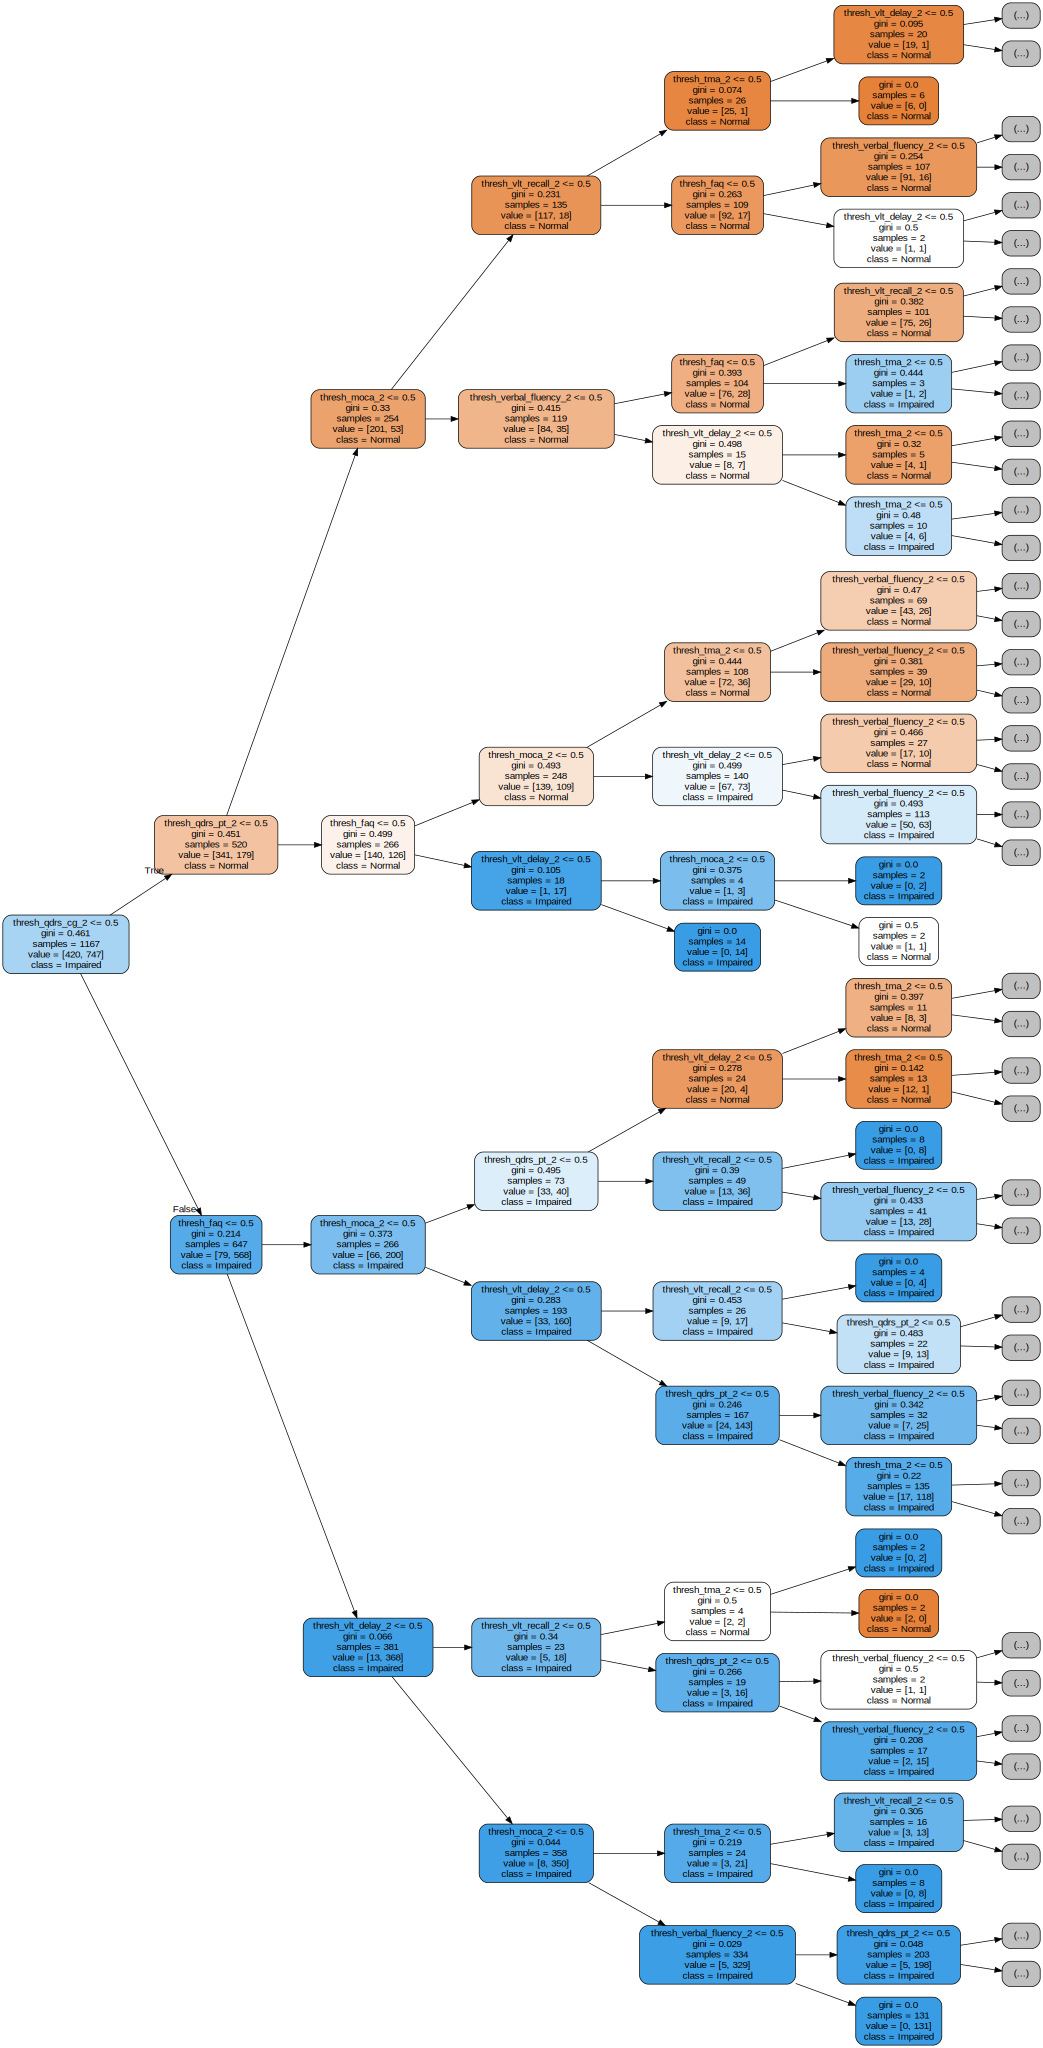

In [0]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_thresh.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
# graph.render(filename='tree_thresh.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [0]:
# from sklearn.tree import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_thresh, adni_us_y2.values.ravel())

y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[107  18]
 [ 23 155]]
Accuracy: 	 0.8646864686468647
AUC: 		 0.8633932584269663
Precision: 	 0.8959537572254336
Recall: 	 0.8707865168539326


#### Totals decision tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_totals, adni_us_y2)


y_test = clinic_us_y2
y_pred = clf.predict(clinic_totals)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 83  42]
 [ 26 152]]
Accuracy: 	 0.7755775577557755
AUC: 		 0.7589662921348314
Precision: 	 0.7835051546391752
Recall: 	 0.8539325842696629


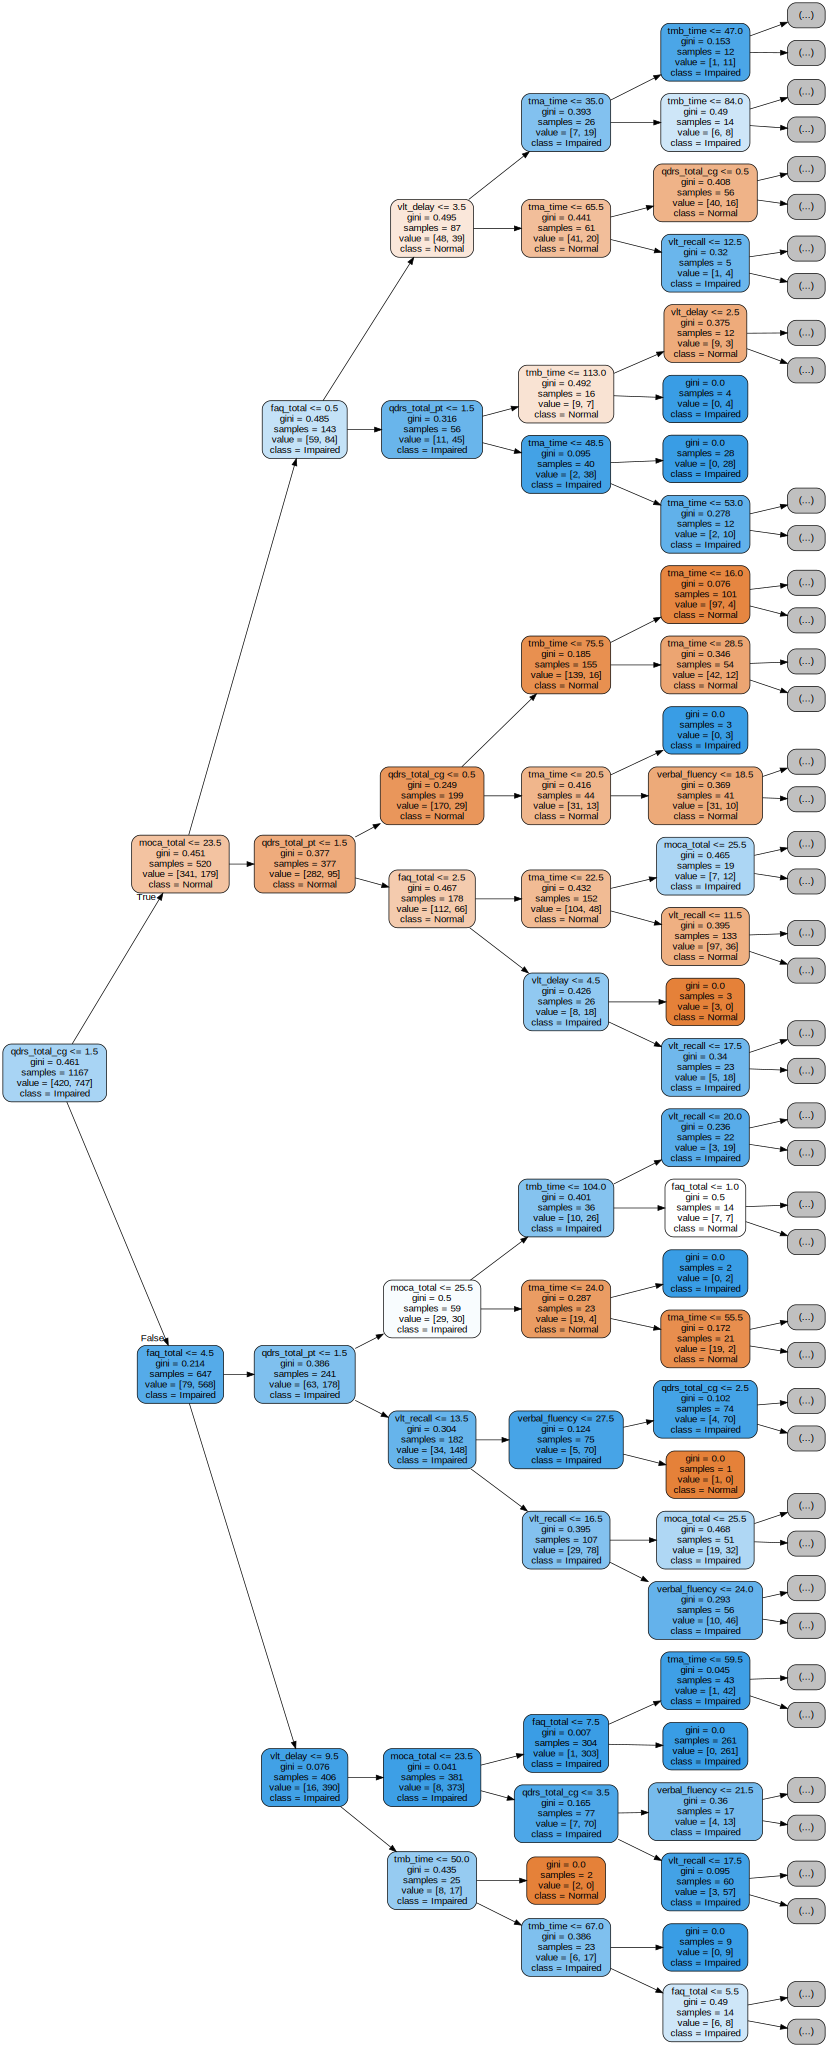

In [0]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_totals.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
graph.render(filename='tree_totals.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [0]:
clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_totals, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_totals)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 88  37]
 [ 22 156]]
Accuracy: 	 0.8052805280528053
AUC: 		 0.7902022471910111
Precision: 	 0.8082901554404145
Recall: 	 0.8764044943820225


#### Separated decision tree, random forest

In [0]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_separated, adni_us_y2)


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

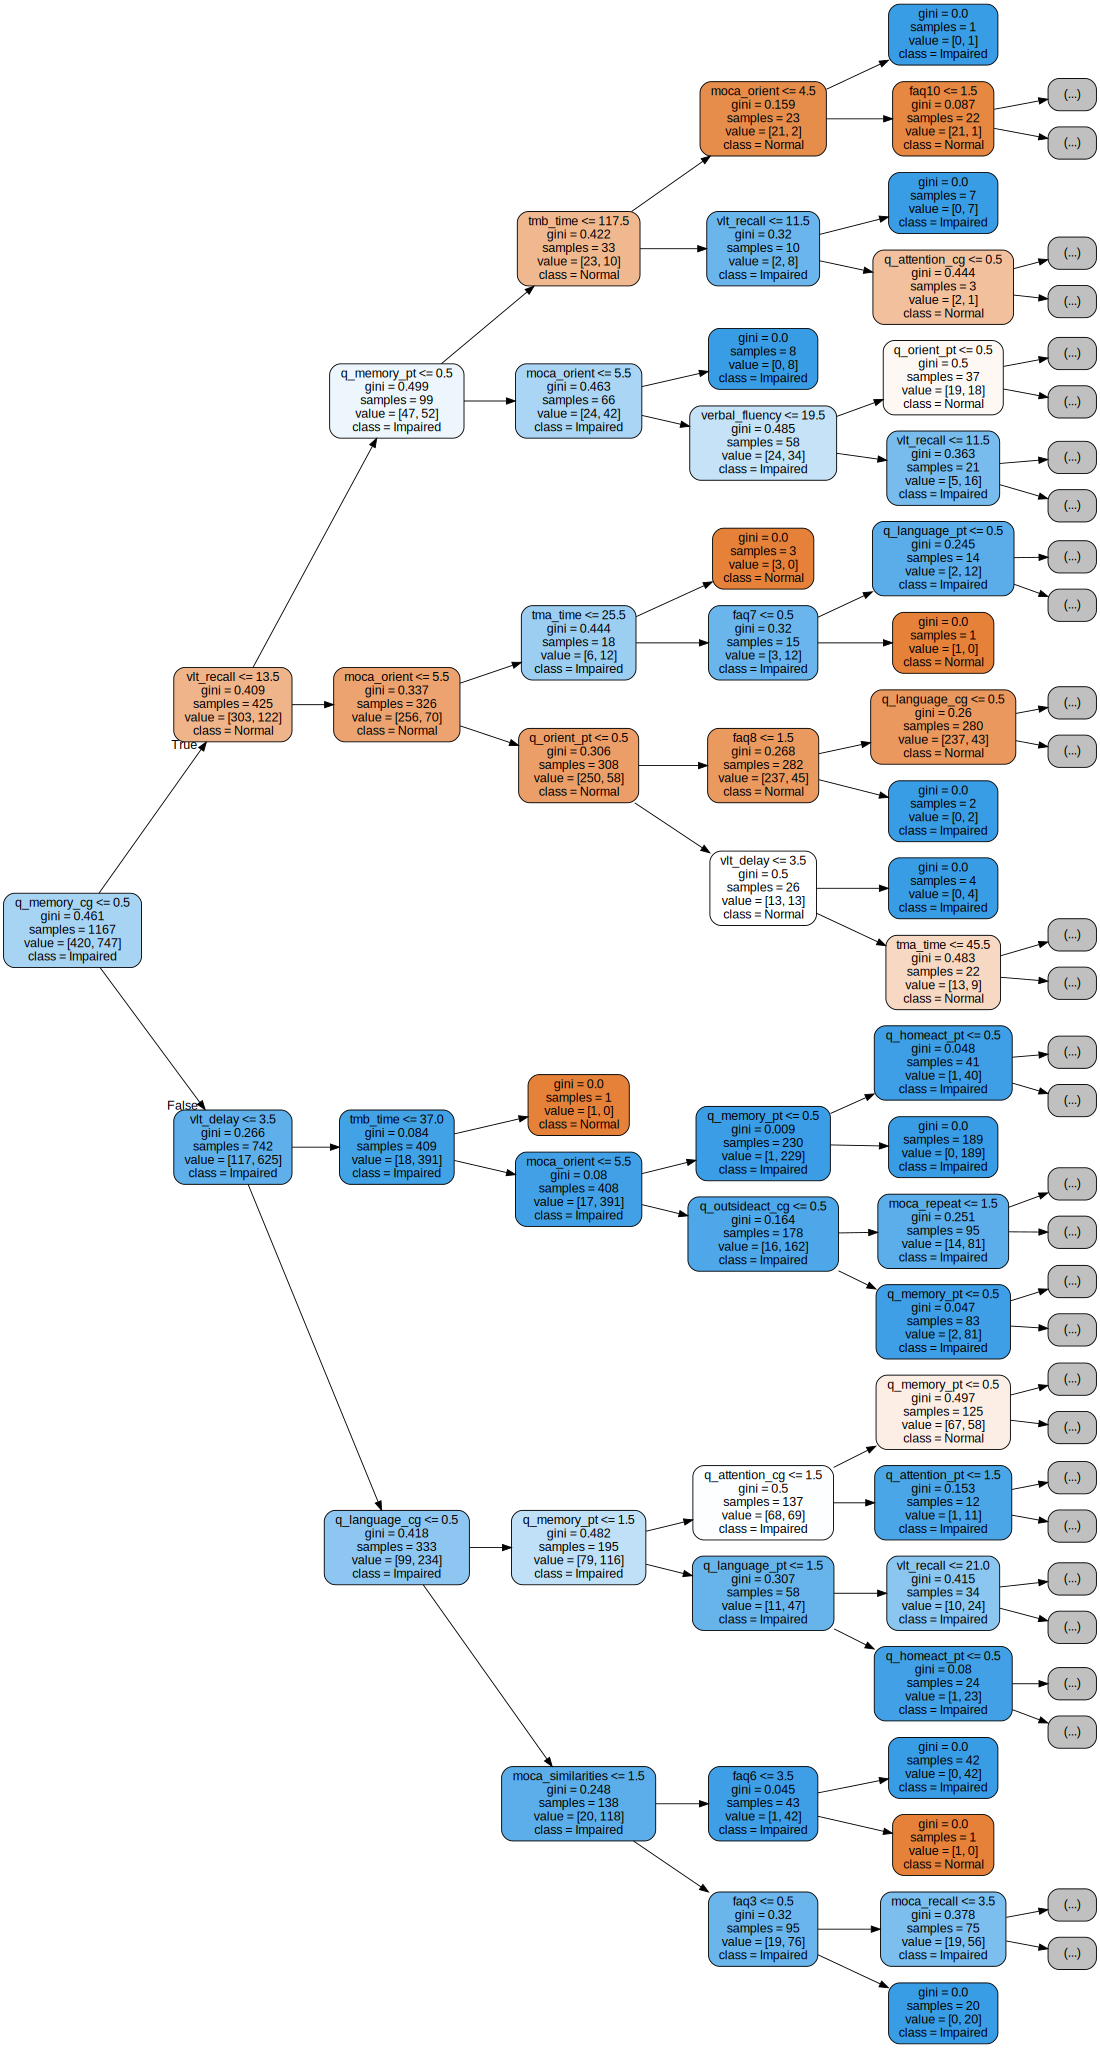

In [0]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_separated.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
graph.render(filename='tree_separated.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [0]:
clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 99  26]
 [ 38 140]]
Accuracy: 	 0.7887788778877888
AUC: 		 0.7892584269662923
Precision: 	 0.8433734939759037
Recall: 	 0.7865168539325843


### Synergistic approach (neural networks)

#### Threshold

In [0]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_thresh, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 88  37]
 [ 23 155]]
Accuracy: 	 0.801980198019802
AUC: 		 0.7873932584269662
Precision: 	 0.8072916666666666
Recall: 	 0.8707865168539326


#### Totaled

In [0]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 98  27]
 [ 31 147]]
Accuracy: 	 0.8085808580858086
AUC: 		 0.8049213483146068
Precision: 	 0.8448275862068966
Recall: 	 0.8258426966292135


#### Separated

In [0]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 98  27]
 [ 31 147]]
Accuracy: 	 0.8085808580858086
AUC: 		 0.8049213483146068
Precision: 	 0.8448275862068966
Recall: 	 0.8258426966292135
